In [2]:
from astropy.table import *
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from astropy.table import hstack
import os
import seaborn as sns
from scipy.stats import binned_statistic
import matplotlib
import matplotlib.backends.backend_pdf
from scipy.stats import chi2, binned_statistic
from cosmic_calc import * 
from scipy.optimize import curve_fit
from bisect import bisect
from datetime import datetime


plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
from scipy.optimize import curve_fit
from statsmodels.stats.weightstats import DescrStatsW

def power(x,a,b):
    return a*x**b

def sigmoid(x,a,b):
    return 1/(1+np.exp(-(x+b)/a+1))


def poisson_interval(k, a=0.3174): 
    lows = chi2.ppf(a/2, 2*k)/2
    highs = chi2.ppf(1-a/2, 2*k+2)/2 
    
    lows=np.array(lows)
    highs=np.array(highs)
    
    lows[np.isnan(lows)]=0
    return lows, highs

In [4]:
dev_path = '/Users/lejay/research/lephare_dev/my_code/'
output_dir = dev_path+'output_cats/'
graham_output_dir = dev_path + 'graham_output_cats/'

In [4]:
# the output catalogs (from graham)
name_tag = '_08squdeg'
detect_limit = '_nolimit'
nz_prior = '_nz_prior'
sfq_added = '_sfq_added'
# nz_prior = ''
cat_output_no_irac_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonirirac_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_output_no_irac_mass_name = graham_output_dir+'cat_out'+name_tag+'_noirac_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_output_no_nir_mass_name = graham_output_dir+'cat_out'+name_tag+'_nonir_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_output_full_mass_name = graham_output_dir+'cat_out'+name_tag+'_allphot_il'+nz_prior+detect_limit+'_formass'+sfq_added+'.fits'
cat_names = [cat_output_no_irac_nir_mass_name, cat_output_no_irac_mass_name, cat_output_no_nir_mass_name, cat_output_full_mass_name]
filter_selections = ['optical only','no irac / with nir','no nir / with irac','full photometry']
flag_name_list = ['flag_optical','flag_nir','flag_irac','flag_nir']

#### write sf/q info and load catalog
see lephare_nuvrk notebook

#### completeness esitmation

In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

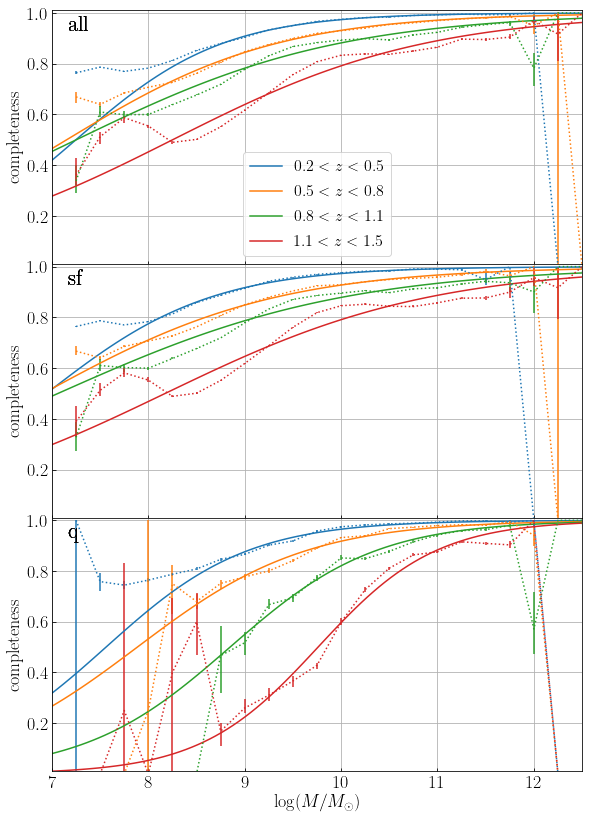

In [6]:
bin_edges = np.linspace(7, 13, num=25)
bin_centers = np.diff(bin_edges) + bin_edges[:-1]
comp_sigmoid_params = Table(names=['z','sfq','a','b'],dtype=['f8','a4','f8','f8'])
inside_j=True

zmins = [0.2,0.5,0.8,1.1]
zmaxs = [0.5,0.8,1.1,1.5]
# zmins = [0.3,0.5,0.7,0.9]
# zmaxs = [0.5,0.7,0.9,1.1]
fig, axs = plt.subplots(3, 1, figsize=(9.5,14),sharex=True, sharey=True)
for i,sfq in enumerate(['all','sf','q']):
    for k,z in enumerate(zmins):
        
        filename = 'completeness_curve_mag/curves/comp_bootstrap_nomaglimit_mass_sfq_nuvrk_myrun_'+sfq+'_'+str(zmins[k])+'_'+str(zmaxs[k])+'.txt'
        curves_mass = np.genfromtxt(filename)
        comp_all = np.median(curves_mass, axis=0)
        comp_all_l = np.percentile(curves_mass,16, axis=0)    
        comp_all_h = np.percentile(curves_mass,84, axis=0)
        if sfq == 'q':
            for j in range(len(comp_all)):
                if j<len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=0
                elif j>len(comp_all)/2 and np.isnan(comp_all[j]):
                    comp_all[j]=1
        else:
            comp_all[np.isnan(comp_all)]=1
        
        # plot data
        axs[i].errorbar(bin_centers,comp_all,yerr=[comp_all-comp_all_l,comp_all_h-comp_all],fmt=colors[k],linestyle=':')
        
        # fitting (modified) sigmoid function to the curves
        popt, pcov = curve_fit(sigmoid, bin_centers[6:-5], comp_all[6:-5],maxfev = 1000)   
        comp_sigmoid_params.add_row([round(z,1),sfq,popt[0],popt[1]])
    
        # plot the sigmoid fit
        x_plot = np.linspace(7,13,100)
        y_plot = sigmoid(x_plot,popt[0],popt[1])
        axs[i].plot(x_plot,y_plot,label=r'$'+str(zmins[k])+'<z<'+str(zmaxs[k])+'$')
    
        axs[i].annotate(sfq,xy=([0.03,0.92]),xycoords='axes fraction',fontsize=22)
        axs[i].set_ylabel('completeness',fontsize=18)
        axs[0].legend(fontsize=16)
        axs[i].set_xlim([7,12.5])
    axs[i].grid()
        
plt.ylim([0.01,1.01])
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=18)
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

comp_sigmoid_params.write('comp_sigmoid_params.fits',overwrite=True)

#### mass vs z
use overall catalog

(6.8, 12.6)

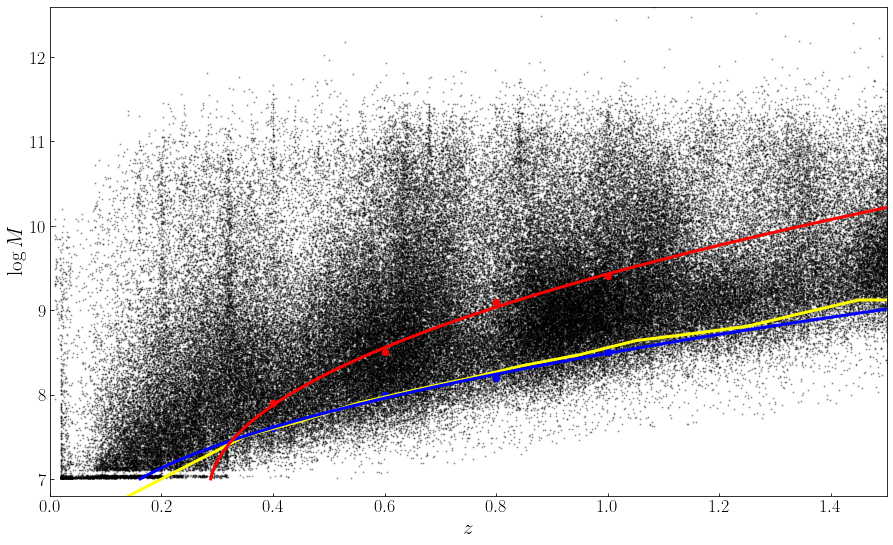

In [5]:
cat = Table.read('/Users/lejay/research/lephare_dev/my_code/graham_output_cats/cat_out_300k_nonir_il_formass.fits')

z_edges = np.linspace(0,1.6,17)
m_mins = []
for z_min in z_edges[:-1]:
    cat_z= cat[cat['Z_ML']>z_min]
    cat_z= cat_z[cat_z['Z_ML']<z_min+0.1]
    
    mass_cut20 = np.percentile(cat_z['MASS_MED_massrun'],20)
    cat_z_lowmass = cat_z[cat_z['MASS_MED_massrun']<mass_cut20]
    m_lims = cat_z_lowmass['MASS_MED_massrun'] + 0.4*(cat_z_lowmass['i']-26)
    m_min =  np.percentile(m_lims,90)
    m_mins.append(m_min)

fig, axs = plt.subplots(1, 1, figsize = (15, 9),sharex=True, sharey=True)
im = plt.scatter(cat['Z_ML'],cat['MASS_MED_massrun'],s=1,c='k',alpha=0.3)
plt.plot(z_edges[:-1]+0.05,m_mins,color='yellow',linewidth=3)

#fit a 2nd order polonomial (mass as independent variable)
# p = np.polyfit(m_mins,z_edges[:-1]+0.05,deg=2)
# mass_plot = np.linspace(7,12.5,1000)
# plt.plot(p[0]*mass_plot**2 + p[1]*mass_plot + p[2], mass_plot, color='b')

# fit for sf and q galaxies (70% completeness from v9 catalog)
xs = [0.4,0.6,0.8,1.0]
ys_sf = [7.6, 8, 8.2, 8.5]
ys_q = [7.9, 8.5, 9.1, 9.4]

# ploy-fit for mass limit
mass_plot = np.linspace(7,12.5,1000)
p_sf = np.polyfit(ys_sf,xs,deg=2) # ploy-fit for sf mass limit
p_q = np.polyfit(ys_q,xs,deg=2)
plt.scatter(xs,ys_sf, color='b',s=40)
plt.scatter(xs,ys_q, color='r',s=40)
plt.plot(p_sf[0]*mass_plot**2 + p_sf[1]*mass_plot + p_sf[2], mass_plot, color='b',linewidth=3)
plt.plot(p_q[0]*mass_plot**2 + p_q[1]*mass_plot + p_q[2], mass_plot, color='r',linewidth=3)

plt.xlabel('$z$',fontsize=21)
plt.ylabel('$\log M$',fontsize=21)
plt.xlim([0,1.5])
plt.ylim([6.8,12.6])

#### fraction of IRAC detected as function of mass

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Text(0.4, 0.05, '$0.8<z<1.1$')

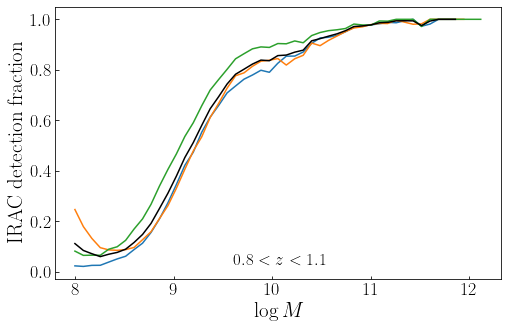

In [154]:
fig, axs = plt.subplots(1, 1, figsize = (8, 5),sharex=True,sharey=True)

irac_detected_frac = []
zmin=0.8
zmax=1.1
for i, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nonir_il_22.4_formass.fits')
    cat = cat[cat['Z_ML']>zmin]
    cat = cat[cat['Z_ML']<zmax]
    
    cond_ch1 = ( (cat['MAG_AUTO_CH1_CORR'] > 0.) & (cat['MAG_AUTO_CH1_CORR'] < 50.) & (cat['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat['MAGERR_AUTO_CH1_CORR'] < 5) )
    cond_ch2 = ( (cat['MAG_AUTO_CH2_CORR'] > 0.) & (cat['MAG_AUTO_CH2_CORR'] < 50.) & (cat['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat['MAGERR_AUTO_CH2_CORR'] < 5) )
    flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
    
    num_bins = 50 # number of bin edges
    mass_bins = np.linspace(8,12.2,num_bins)
    
    all_count = binned_statistic(cat['MASS_MED_massrun'], cat['MASS_MED_massrun'], statistic='count',bins=mass_bins)[0]
    irac_detected_count = binned_statistic(cat[flag_irac>0]['MASS_MED_massrun'], cat[flag_irac>0]['MASS_MED_massrun'], statistic='count',bins=mass_bins)[0]
    irac_detected_frac.append(irac_detected_count/all_count)
    axs.plot(mass_bins[:-1],irac_detected_count/all_count)
    
irac_detected_frac = np.array(irac_detected_frac)
irac_detected_frac_avg = np.average(irac_detected_frac,axis=0,weights=[4.4,3.7,3.7])  

axs.plot(mass_bins[:-1],irac_detected_frac_avg,color='k')
axs.set_xlabel('$\log M$',fontsize=21)
axs.set_ylabel('IRAC detection fraction',fontsize=21)
axs.annotate('$'+str(zmin)+'<z<'+str(zmax)+'$',xy=([0.4,0.05]),xycoords='axes fraction',fontsize=17,color='k')


#### estimate area

In [81]:
cosmos_v9 = Table.read('clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits')
inside_j=cosmos_v9['inside_j']

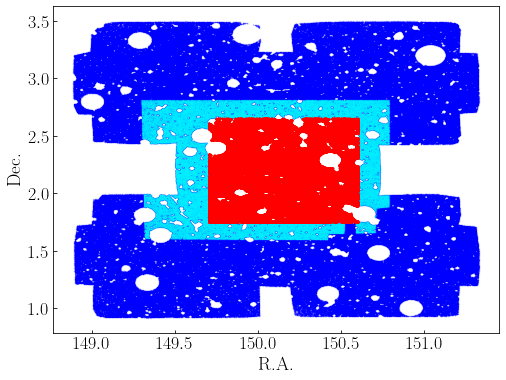

In [82]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6),sharex=True, sharey=True)
cat_output_full_name = cat_output_no_nir_mass_name
cat_output = Table.read(cat_output_full_name)

plt.scatter(cosmos_v9['RA'],cosmos_v9 ['DEC'],s=0.1,alpha=0.1,c='b')
plt.scatter(cosmos_v9[inside_j]['RA'],cosmos_v9[inside_j]['DEC'],s=0.1,alpha=0.1,c='cyan')
plt.scatter(cat_output['RA'],cat_output['DEC'],s=1,color='r')
plt.xlabel('R.A.',fontsize=19)
plt.ylabel('Dec.',fontsize=19)
plt.savefig('/Users/lejay/Desktop/smf_paper/sky_plot.png')


In [6]:
# total solid angle (all sky)
total_soid_angle = 360**2/np.pi

# COSMOS area
d_ra = 151.9 - 148.3
dec_1 = 0.6
dec_2 = 4.0
area = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 148.3]
cat_random = cat_random[cat_random['RA'] < 151.9]
cat_random = cat_random[cat_random['DEC'] > 0.6]
cat_random = cat_random[cat_random['DEC'] < 4.0]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area = area * len(cat_random_nomask)/len(cat_random)
print("COSMOS", area, round(np.mean(cat_random_nomask['RA']),3), round(np.mean(cat_random_nomask['DEC']),3))

# central COSMOS area (08squdeg)
d_ra = 150.6 - 149.7
dec_1 = 1.75
dec_2 = 2.65
area_central_cosmos = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 149.7]
cat_random = cat_random[cat_random['RA'] < 150.6]
cat_random = cat_random[cat_random['DEC'] > 1.75]
cat_random = cat_random[cat_random['DEC'] < 2.65]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_central_cosmos = area_central_cosmos * len(cat_random_nomask)/len(cat_random)
print("central COSMOS", area_central_cosmos, round(np.mean(cat_random_nomask['RA']),3), round(np.mean(cat_random_nomask['DEC']),3))

# ELAIS area
d_ra = 245. - 240.
dec_1 = 53.3
dec_2 = 56.9
area_elais = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/ELAIS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 240]
cat_random = cat_random[cat_random['RA'] < 245]
cat_random = cat_random[cat_random['DEC'] > 53.3]
cat_random = cat_random[cat_random['DEC'] < 56.9]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_elais = area_elais * len(cat_random_nomask)/len(cat_random)
print("ELAIS",area_elais, round(np.mean(cat_random_nomask['RA']),3), round(np.mean(cat_random_nomask['DEC']),3))

# DEEP area
d_ra = 354. - 350.3
dec_1 = -1.6
dec_2 = 1
area_deep = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/DEEP_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 350.3]
cat_random = cat_random[cat_random['RA'] < 354]
cat_random = cat_random[cat_random['DEC'] > -1.6]
cat_random = cat_random[cat_random['DEC'] < 1]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_deep = area_deep * len(cat_random_nomask)/len(cat_random)
print("DEEP",area_deep, round(np.mean(cat_random_nomask['RA']),3), round(np.mean(cat_random_nomask['DEC']),3))

# XMM area
d_ra = 37.8 - 33.6
dec_1 = -6.2
dec_2 = -3.2
area_xmm = 360**2*(d_ra*np.pi/180.)*(np.sin(dec_2*np.pi/180.)-np.sin(dec_1*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
# masked area (estimate from random point catalog)
cat_random = Table.read('CUT_deep_catalogs/random_point_cat/XMM-LSS_deep_random_point.fits')
cat_random = cat_random[cat_random['RA'] > 33.6]
cat_random = cat_random[cat_random['RA'] < 37.8]
cat_random = cat_random[cat_random['DEC'] > -6.2]
cat_random = cat_random[cat_random['DEC'] < -3.2]
cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
area_xmm = area_xmm * len(cat_random_nomask)/len(cat_random)
print("XMM",area_xmm, round(np.mean(cat_random_nomask['RA']),3), round(np.mean(cat_random_nomask['DEC']),3))

COSMOS 4.406492756179495 150.114 2.202
central COSMOS 0.6271818752015379 150.144 2.185
ELAIS 3.728927321927289 242.768 54.982
DEEP 3.7029813439273442 352.059 -0.25
XMM 7.2547367302496015 35.694 -4.699


#### comoving cosmic volume
$H_0=69.6$ km/s/Mpc, $\Omega_M=0.286$

In [7]:
V2 = 2.336 # cosmic volume at z=0.2, Gpc^3
V5 = 29.127
V8 = 94.303
V11 = 194.160
V15 = 365.540

Va = (V5-V2)*area/total_soid_angle*10**9 # in Mpc^3
Vb = (V8-V5)*area/total_soid_angle*10**9 # in Mpc^3
Vc = (V11-V8)*area/total_soid_angle*10**9 # in Mpc^3
Vd = (V15-V11)*area/total_soid_angle*10**9 # in Mpc^3
cosmic_volumes = [Va,Vb,Vc,Vd]

##### calculate the combined SMF

In [8]:
mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]
fit_start_shift = [2,2,0,-5]
end_point = [-3,-3,-6,-3]

In [22]:
cat_type = 'pcat' # all, cosmos, central_cosmos or central_cosmos_v or v9pcat or pcat
if cat_type == 'all' or 'pcat' in cat_type:
    cat_names = ['COSMOS_deep','DEEP_deep','ELAIS_deep']
    areas = [area, area_deep,area_elais]
elif cat_type == 'cosmos':
    cat_names = ['COSMOS_deep']
    areas = [area]
else:
    cat_names = ['COSMOS_deep']
    areas = [area_central_cosmos]

sfq = 'q'  # all,sf,q
phot_config = 'nonir'
z_outlier_corr = 'True'  # points or smooth or False
sfq_keyname = 'sfq_nuvrk_myrun_free' # sfq_nuvrk_myrun_[free], ([fix_slope], [evolving]]) or sfProb or sfProb_sfq
mass_offset_flag = True
comp_corr = False
fit_const_sigma = False

z_bins = 'original'
if z_bins == 'original':
    z_mins = [0.2, 0.5, 0.8, 1.1]
    z_maxs = [0.5, 0.8, 1.1, 1.5]
else: #'alt'
    z_mins = [0.2, 0.35, 0.7, 0.9]
    z_maxs = [0.35, 0.7, 0.9, 1.1]

sigma_ms = [0.25,0.2,0.2,0.2] # one-sigma mass error to apply to convolution
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
bin_centers = bins[:-1]+bin_size/2
cat_comp = Table.read('comp_sigmoid_params.fits')

fit_params = []
fit_params_err = []
for i in range(len(z_mins)):
    total_area = 0

    x_total = np.zeros(num_bins-1)
    y_total = np.zeros(num_bins-1)
    yerr_minus_sq_total = np.zeros(num_bins-1)
    yerr_plus_sq_total = np.zeros(num_bins-1)
    for k,cat_name in enumerate(cat_names):
        print(z_mins[i],z_maxs[i],sfq, cat_name)
        
        # Read in catalog
        if cat_type == 'all' or cat_type == 'cosmos':
            cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass_sfq_added.fits')
            z_keyname = 'Z_ML'
            m_keyname = 'MASS_MED_massrun'
        elif cat_type == 'pcat':
            cat = Table.read(graham_output_dir+'pcat_'+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass_sfq_added.fits')
            z_keyname = 'Z_COMBINE'
            m_keyname = 'MASS_MED_massrun'
        elif cat_type == 'v9pcat':
            cat = Table.read(graham_output_dir+'v9pcat_'+cat_name+'_cat_out_nomaglimit_'+phot_config+'_il_nz_prior_formass_sfq_added.fits')
            z_keyname = 'Z_COM'
            m_keyname = 'MASS_MED_massrun'
        elif cat_type == 'central_cosmos':
            cat = Table.read(graham_output_dir+'cat_out_08squdeg_'+phot_config+'_il_nz_prior_nolimit_formass_sfq_added.fits')
            z_keyname = 'Z_ML'
            m_keyname = 'MASS_MED_massrun'
        else:
            cat = Table.read(dev_path+'input_cats/COSMOS_deep_base.fits') # use Vincet's redshift and mass here (ZPHOT and MASS_MED)
            z_keyname = 'ZPHOT'
            m_keyname = 'MASS_MED'
        print(cat_name, len(cat),round(len(cat)/areas[k],1))
        
        # optical flag
        # cond_U = ( (cat['u'] > 0.) & (cat['u'] < 50.) & (cat['u_err'] > 0.) & (cat['u_err'] < 0.3) )| \
        #  ( (cat['uS'] > 0.) & (cat['uS'] < 50.) & (cat['uS_err'] > 0.) & (cat['uS_err'] < 0.3) )
        # cond_g = ( (cat['g'] > 0.) & (cat['g'] < 50.) & (cat['g_err'] > 0.) & (cat['g_err'] < 0.3) ) 
        # cond_r = ( (cat['r'] > 0.) & (cat['r'] < 50.) & (cat['r_err'] > 0.) & (cat['r_err'] < 0.3) )
        # cond_i = ( (cat['i'] > 0.) & (cat['i'] < 50.) & (cat['i_err'] > 0.) & (cat['i_err'] < 0.3) )
        # cond_z = ( (cat['z'] > 0.) & (cat['z'] < 50.) & (cat['z_err'] > 0.) & (cat['z_err'] < 0.3) )
        # cond_y = ( (cat['y'] > 0.) & (cat['y'] < 50.) & (cat['y_err'] > 0.) & (cat['y_err'] < 0.3) )
        # flag_optical = cond_U.astype(int) + cond_g.astype(int) + cond_r.astype(int) + cond_i.astype(int) + cond_z.astype(int) + cond_y.astype(int)
        # cat = cat[flag_optical>2]
        
        # flag for massive gals with no irac detection
        # cond_ch1 = ( (cat['MAG_AUTO_CH1_CORR'] > 0.) & (cat['MAG_AUTO_CH1_CORR'] < 50.) & (cat['MAGERR_AUTO_CH1_CORR'] > 0.) & (cat['MAGERR_AUTO_CH1_CORR'] < 0.5) )
        # cond_ch2 = ( (cat['MAG_AUTO_CH2_CORR'] > 0.) & (cat['MAG_AUTO_CH2_CORR'] < 50.) & (cat['MAGERR_AUTO_CH2_CORR'] > 0.) & (cat['MAGERR_AUTO_CH2_CORR'] < 0.5) )
        # flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 
        # flag_wrongmassive = (cat['MASS_MED_massrun']>11.0) & (flag_irac<=1)
        # cat = cat[flag_wrongmassive==False] # remove them
        # flag_wrongmassive2 = (cat['MASS_MED_massrun']>11.0) & (cat['MAG_AUTO_CH1_CORR']>23)
        # cat = cat[flag_wrongmassive2==False] # remove them
        
        cat_z = cat[cat[z_keyname]>z_mins[i]]
        cat_z = cat_z[cat_z[z_keyname]<z_maxs[i]]
        print(cat_name, len(cat_z),round(len(cat_z)/areas[k],1))
        
        # comepleteness values
        if sfq =='sf':
            comp_limit_index = bisect(bins, mass_comp_sf_80[i])
        elif sfq == 'q':
            comp_limit_index = bisect(bins, mass_comp_q_80[i])
        else:
            comp_limit_index = bisect(bins, mass_comp_80[i])
            sfProb_list = np.ones(len(cat_z))
            
        if 'sfq' in sfq_keyname:
            if sfq =='sf':
                cat_z = cat_z[cat_z[sfq_keyname]==1.0]
                sfProb_list = np.ones(len(cat_z))
            elif sfq == 'q':
                cat_z = cat_z[cat_z[sfq_keyname]==0.0]
                sfProb_list = np.ones(len(cat_z))
        elif sfq_keyname == 'sfProb_cut':
            if sfq =='sf':
                cat_z = cat_z[cat_z['sfProb']>0.4]
                sfProb_list = np.ones(len(cat_z))
            elif sfq == 'q':
                cat_z = cat_z[cat_z['sfProb']<0.4]
                sfProb_list = np.ones(len(cat_z))
        elif sfq_keyname == 'sfProb': # sfProb
            if sfq == 'sf':
                sfProb_list = cat_z['sfProb']
            elif sfq == 'q':
                sfProb_list = 1 - cat_z['sfProb']
            else:
                sfProb_list = np.ones(len(cat_z))
        else:
            raise ValueError('Wrong sfq keyname')
            
        # correction for masses (by m_myrun - m_c20 mass offset)
        if z_bins == 'original' and mass_offset_flag:
            mass_offset = np.load('mass_err/mass_err_median_all_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
            mass_offset_x = mass_offset[0]
            mass_offset_y = mass_offset[1]
            for gal in cat_z:
                if gal['MASS_MED_massrun'] > 8:
                    gal['MASS_MED_massrun'] = gal['MASS_MED_massrun'] - np.interp(gal['MASS_MED_massrun'], mass_offset_x, mass_offset_y)
            
        # 1/vmax normalization
        inv_volumes = [] # sum of inverse of volumes
        for bin_num in tqdm(range(num_bins-1)):
            inv_volume = 0
            cat_massbin = cat_z[np.logical_and(cat_z[m_keyname]>bins[bin_num], cat_z[m_keyname]<bins[bin_num+1])]
            sfProb_list_massbin = sfProb_list[np.logical_and(cat_z[m_keyname]>bins[bin_num], cat_z[m_keyname]<bins[bin_num+1])]
            
            zmax_in_bin = p_sf[0]*bins[bin_num]**2 + p_sf[1]*bins[bin_num] + p_sf[2]
            if zmax_in_bin > z_maxs[i]:
                total_volume = ( cosmic_calc(z_maxs[i]) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                inv_volume = sum(sfProb_list_massbin) / (total_volume*areas[k]/total_soid_angle)
            else:
                max_gals_in_bin = 100
                if len(cat_massbin)> max_gals_in_bin:
                    select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                    cat_select = cat_massbin[select_ids]
                    sfProb_list_select = sfProb_list_massbin[select_ids]
                else:
                    cat_select = cat_massbin
                    sfProb_list_select = sfProb_list_massbin
                    
                for idx,gal in enumerate(cat_select):
                    # if sfq == 'q':
                    #     zmax = p_q[0]*gal[m_keyname]**2 + p_q[1]*gal[m_keyname] + p_q[2]
                    # else:
                    zmax = p_sf[0]*gal[m_keyname]**2 + p_sf[1]*gal[m_keyname] + p_sf[2]
                    total_volume = ( cosmic_calc(min(zmax,z_maxs[i])) - cosmic_calc(z_mins[i]) )*1e9 # in Mpc^3
                    inv_volume += sfProb_list_select[idx] / (total_volume*areas[k]/total_soid_angle) * len(cat_massbin) / len(cat_select)
                    
            inv_volumes.append(inv_volume)            
        
        #### histograms (normalization and correction) 
        mass_list = cat_z[m_keyname]
        n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
        sampling_factor = 1. 
        if sfq == 'sf':
            comp_param = cat_comp[4+i]
        elif sfq == 'q':
            comp_param = cat_comp[8+i]
        else:
            comp_param = cat_comp[i]
        
        # correct for detection completeness
        completeness = sigmoid(bins[:-1]+bin_size/2, comp_param[2], comp_param[3])
        if comp_corr:
            weights = 1/bin_size/sampling_factor/completeness #completeness
        else:
            weights = 1/bin_size/sampling_factor
        x = bins[:-1]+np.diff(bins)/2       # log(M)
        y = np.array(inv_volumes)*weights   # density per mass bin
        
        # correction for redshift outliers
        if z_outlier_corr!='False' and z_bins == 'original':
            if z_outlier_corr == 'smooth':
                outlier_corr = np.load('outlier_corr_frac_all_'+str(z_mins[i])+'_smooth.npy')
            else:
                outlier_corr = np.load('outlier_corr_frac_all_'+str(z_mins[i])+'.npy')
            oc_x = outlier_corr[0] # mass at which outlier correction was sampled
            oc_y = outlier_corr[1] # outlier correction values
            oc_smfbins = np.interp(bin_centers,oc_x,oc_y) # interpolate
            y = y * oc_smfbins
       
        #### SMF uncertainty ###############
        if z_bins == 'original':
            # mass errorbars 
            arr = np.load('mass_err/mass_err_overall_'+str(sfq)+'_'+str(z_mins[i])+'.npy')
            mass_err_x = arr[0]
            mass_err_y = arr[1]
            hist_stack = []
            for r in range(20):
                mass_list_rand = mass_list + np.random.normal(0,np.interp(mass_list,mass_err_x,mass_err_y))
                hist,bin_edges = np.histogram(mass_list_rand,bins=bins)
                hist_stack.append(hist)
    
            mass_errbar_minus = np.mean(np.array(hist_stack),axis=0) - np.percentile(np.array(hist_stack),16,axis=0)
            mass_errbar_plus = np.percentile(np.array(hist_stack),84,axis=0) - np.mean(np.array(hist_stack),axis=0)
        
            # poisson errorbars
            poisson_errbar_minus = n - poisson_interval(n, a=0.3174)[0]
            poisson_errbar_plus = poisson_interval(n, a=0.3174)[1] - n
            
            # cosmic variance 
            cv = np.load('cosmic_variance/cv_'+str(z_mins[i])+'.npy')
            cv_x = cv[0] # mass at which cv was sampled
            cv_y = cv[1] # cv values (in percentage)
            cv_errbar_percentage = np.interp(bin_centers,cv_x,cv_y) # interpolate
            cv_errbar = n * cv_errbar_percentage/100
            
            # total SMF errorbars
            errbar_minus = np.sqrt(mass_errbar_minus**2 + poisson_errbar_minus**2 + cv_errbar**2)
            errbar_plus = np.sqrt(mass_errbar_plus**2 + poisson_errbar_plus**2 + cv_errbar**2)
            yerr_minus = errbar_minus/n * y
            yerr_minus[np.isnan(yerr_minus)]=1e-9
            yerr_plus = errbar_plus/n * y
            yerr_plus[np.isnan(yerr_plus)]=1e-9
        else:
            # total SMF errorbars
            errbar_minus = 1e-10*np.ones(len(y))
            errbar_plus = 1e-10*np.ones(len(y))
            yerr_minus = errbar_minus/n * y
            yerr_plus = errbar_plus/n * y
        
        # save to disk (field specific)
        y_err = (yerr_minus+yerr_plus)/2/areas[k]
        smf_field = np.stack([y, y_err, y_err/areas[k]]) 
        np.save('smf_'+cat_name+'_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_field)
        
        ######## add up SMF ################
        total_area += areas[k]
        y_total += y*areas[k]
        yerr_minus_sq_total += yerr_minus**2*areas[k]**2
        yerr_plus_sq_total += yerr_plus**2*areas[k]**2
    
    # calculate overall SMF
    yerr_minus_total = np.sqrt(yerr_minus_sq_total)
    yerr_plus_total = np.sqrt(yerr_plus_sq_total)
    y_fitting = y_total/total_area
    y_fitting_err = (yerr_minus_total+yerr_plus_total)/2/total_area
    
    # save to disc
    smf_total = np.stack([y_fitting, y_fitting_err, yerr_plus_total/total_area]) 
    np.save('smf_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i]), smf_total)
    
    ######## SMF Fitting ##############
    
    #convolved schechter fit
    # popt, pcov, chi2_ = fit_schechter_con(x,y,yerr,comp_limit_index+fit_start_shift[i],-5,0.15)
    # print(popt)
    # print(np.sqrt(np.diag(pcov)))
    # x_plot = np.linspace(8,12.5,100)
    # axs[row][col].plot(x_plot,schechter(x_plot,popt[0] ,popt[1], popt[2]),color='b',alpha=0.5)
    # axs[row][col].plot(x_plot,con_schechter(x_plot, popt[0] ,popt[1], popt[2],0.15),color='b',alpha=0.5)

    # double schechter fit
    # popt, pcov, chi2_ = fit_double_schechter(bin_centers, y_fitting*1e3, y_fitting_err, comp_limit_index+fit_start_shift[i],end_point[i])
    # print(popt)
    # print(np.sqrt(np.diag(pcov)))
    # fit_params.append(popt)
    # fit_params_err.append(np.sqrt(np.diag(pcov))) 
    
    # convolved double schechter fit
#     if sfq=='q' and (i==2 or i==3):
#         double_fit = False
#     else:
#         double_fit = True
        
#     if fit_const_sigma:
#         popt, pcov, chi2_ = fit_double_schechter_con(bin_centers, y_fitting*1e3, y_fitting_err, comp_limit_index+fit_start_shift[i],end_point[i], sigma_ms[i],double_fit=double_fit)
#         fit_params.append(popt)
#         fit_params_err.append(np.sqrt(np.diag(pcov))) 
#     else:
#         popt, pcov, chi2_ = fit_double_schec_varysigma_con(bin_centers, y_fitting*1e3, y_fitting_err, comp_limit_index+fit_start_shift[i],end_point[i], z_mins[i],double_fit=double_fit)
#         fit_params.append(popt)
#         fit_params_err.append(np.sqrt(np.diag(pcov))) 
#     print(popt)
    
# if fit_const_sigma:    
#     np.save('fit_param_dsi_'+sfq, np.array(fit_params))
#     np.save('fit_param_err_dsi_'+sfq, np.array(fit_params_err))
# else:
#     np.save('fit_param_varysigma_'+sfq, np.array(fit_params))
#     np.save('fit_param_err_varysigma_'+sfq, np.array(fit_params_err)) 

0.2 0.5 q COSMOS_deep
COSMOS_deep 1506040 341777.5
COSMOS_deep 158053 35868.2


100%|██████████| 49/49 [00:01<00:00, 39.66it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


0.2 0.5 q DEEP_deep
DEEP_deep 1228827 331848.0
DEEP_deep 120077 32427.1


100%|██████████| 49/49 [00:01<00:00, 36.44it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


0.2 0.5 q ELAIS_deep
ELAIS_deep 1248400 334788.0
ELAIS_deep 138347 37101.0


100%|██████████| 49/49 [00:00<00:00, 200.70it/s]


0.5 0.8 q COSMOS_deep
COSMOS_deep 1506040 341777.5
COSMOS_deep 249554 56633.2


100%|██████████| 49/49 [00:00<00:00, 62.24it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


0.5 0.8 q DEEP_deep
DEEP_deep 1228827 331848.0
DEEP_deep 202850 54780.2


100%|██████████| 49/49 [00:00<00:00, 80.73it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


0.5 0.8 q ELAIS_deep
ELAIS_deep 1248400 334788.0
ELAIS_deep 210734 56513.3


100%|██████████| 49/49 [00:00<00:00, 236.67it/s]


0.8 1.1 q COSMOS_deep
COSMOS_deep 1506040 341777.5
COSMOS_deep 235336 53406.6


100%|██████████| 49/49 [00:00<00:00, 61.55it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


0.8 1.1 q DEEP_deep
DEEP_deep 1228827 331848.0
DEEP_deep 189881 51277.9


100%|██████████| 49/49 [00:00<00:00, 88.88it/s] 
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


0.8 1.1 q ELAIS_deep
ELAIS_deep 1248400 334788.0


  0%|          | 0/49 [00:00<?, ?it/s]

ELAIS_deep 194912 52270.3


100%|██████████| 49/49 [00:00<00:00, 321.94it/s]


1.1 1.5 q COSMOS_deep
COSMOS_deep 1506040 341777.5
COSMOS_deep 203775 46244.3


100%|██████████| 49/49 [00:00<00:00, 67.62it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


1.1 1.5 q DEEP_deep
DEEP_deep 1228827 331848.0
DEEP_deep 198837 53696.5


100%|██████████| 49/49 [00:00<00:00, 86.12it/s]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:227: RuntimeWarning: invalid value encountered in multiply
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: divide by zero encountered in true_divide
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:229: RuntimeWarning: invalid value encountered in multiply


1.1 1.5 q ELAIS_deep
ELAIS_deep 1248400 334788.0


  0%|          | 0/49 [00:00<?, ?it/s]

ELAIS_deep 180883 48508.1


100%|██████████| 49/49 [00:00<00:00, 256.15it/s]


#### Cosmic Variance

In [10]:
# cosmic variance
cat = Table.read(graham_output_dir+'COSMOS_deep_cat_out_nonir_il_22.4_formass_sfq_added.fits')
cat = cat[cat['MASK'] == 0]  # unmasked
cat = cat[cat['OBJ_TYPE'] == 0]  # galaxies

# ra/dec grid
grid = (2,3)
ra_min = 148.3
ra_max = 151.9
dec_min = 0.6
dec_max = 4.0
ra_list = np.linspace(ra_min,ra_max,grid[0]+1)
dec_list = np.linspace(dec_min,dec_max,grid[1]+1)

# add column to indicate grid spot
grid_data = np.zeros(len(cat))
grid_areas = []
count = 0
for i in range(len(ra_list)-1):
    ra_grid_min = ra_list[i]
    ra_grid_max = ra_list[i+1]
    for k in range(len(dec_list)-1):
        dec_grid_min = dec_list[k]
        dec_grid_max = dec_list[k+1]
        
        count += 1
        
        # cut catalog
        cond_ra = (cat['RA']>ra_grid_min) & (cat['RA']<ra_grid_max)
        cond_dec = (cat['DEC']>dec_grid_min) & (cat['DEC']<dec_grid_max)
        grid_data += count*(cond_ra.astype(int)*cond_dec.astype(int)) # grid spot number

        # area estimate for each grid
        area_grid = 360**2*((ra_grid_max-ra_grid_min)*np.pi/180.)*(np.sin(dec_grid_max*np.pi/180.)-np.sin(dec_grid_min*np.pi/180.))/ (4*np.pi**2) # solid angle, in square degrees
        cat_random = Table.read('CUT_deep_catalogs/random_point_cat/COSMOS_deep_random_point.fits')
        cat_random = cat_random[cat_random['RA'] > ra_grid_min]
        cat_random = cat_random[cat_random['RA'] < ra_grid_max]
        cat_random = cat_random[cat_random['DEC'] > dec_grid_min]
        cat_random = cat_random[cat_random['DEC'] < dec_grid_max]
        cat_random_nomask = cat_random[np.logical_and(cat_random['MASK']!=0, cat_random['inside']==0) ]
        area_grid = area_grid * len(cat_random_nomask)/len(cat_random)
        grid_areas.append(area_grid)
        
col_grid = Column(name='grid',data=grid_data)    
cat.add_column(col_grid)

0.2 0.5


NameError: name 'grid' is not defined

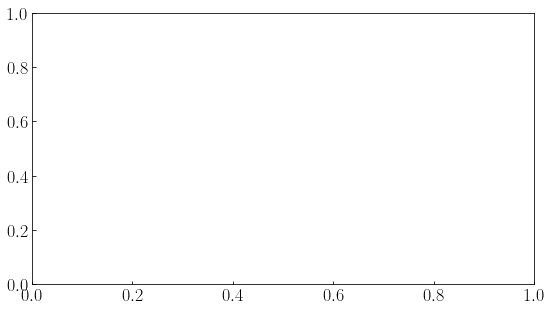

In [35]:
fig, axs = plt.subplots(1, 1, figsize = (9, 5),sharex=True)
mass_est_list = [9.5,10,10.5,11.0,11.5]
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)

for z_index in range(len(z_mins)):
    print(z_mins[z_index],z_maxs[z_index])
    cat_z = cat[cat['Z_ML']>z_mins[z_index]]
    cat_z = cat_z[cat_z['Z_ML']<z_maxs[z_index]]
    smf_scatter = []
    smf_scatter_std = []
    for i_exclude in tqdm(range(1,grid[0]*grid[1]+1)):
        smfs = []
        grid_exclude_indices = []
        for i in range(1,grid[0]*grid[1]+1): 
            # remove one grid spot at a time
            if i != i_exclude:
                if grid_areas[i-1]>0.001:
                    cat_cv=cat_z[cat_z['grid']==i]
                    area_cv = grid_areas[i-1]
                else:
                    grid_exclude_indices.append(i-1)
                    continue
            else:
                grid_exclude_indices.append(i-1)
                continue
            
            # mass offset correction
            cat_cv['MASS_MED_massrun'] = cat_cv['MASS_MED_massrun'] - 0.05
            
            # 1/vmax normalization
            num_bins = 50 # number of bin edges
            inv_volumes = [] # sum of inverse of volumes
            bins = np.linspace(8,12.2,num_bins)
            mass_bincenters = bins[:-1]+np.diff(bins)/2       # log(M)
            bin_size = bins[1]-bins[0]
            cat_comp = Table.read('comp_sigmoid_params.fits')   
            for bin_num in range(num_bins-1):
                inv_volume = 0
                cat_massbin = cat_cv[np.logical_and(cat_cv['MASS_MED_massrun']>bins[bin_num], cat_cv['MASS_MED_massrun']<bins[bin_num+1])]
                zmax_in_bin = p_sf[0]*bins[bin_num]**2 + p_sf[1]*bins[bin_num] + p_sf[2]
                if zmax_in_bin > 0.5:
                    total_volume = ( cosmic_calc(0.5) - cosmic_calc(0.2) )*1e9 # in Mpc^3
                    inv_volume = len(cat_massbin) / (total_volume*area_cv/total_soid_angle)
                else:
                    max_gals_in_bin = 100
                    if len(cat_massbin)> max_gals_in_bin:
                        select_ids = np.random.choice(np.arange(len(cat_massbin)), size=max_gals_in_bin, replace=False)
                        cat_select = cat_massbin[select_ids]
                    else:
                        cat_select = cat_massbin
                    
                    for gal in cat_select:
                        zmax = p_sf[0]*gal['MASS_MED_massrun']**2 + p_sf[1]*gal['MASS_MED_massrun'] + p_sf[2]
                        total_volume = ( cosmic_calc(min(zmax,0.5)) - cosmic_calc(0.2) )*1e9 # in Mpc^3
                        inv_volume += 1 / (total_volume*area_cv/total_soid_angle) * len(cat_massbin) / len(cat_select)
                
                inv_volumes.append(inv_volume)            
                
            #### histograms (normalization and correction) 
            mass_list = cat_cv['MASS_MED_massrun']
            n,edges = np.histogram(mass_list,range=(8,12.2),bins=bins)
            
            sampling_factor = 1. 
            comp_param = cat_comp[0]
            completeness = sigmoid(bins[:-1]+bin_size/2, comp_param[2], comp_param[3])
            weights = 1/bin_size/sampling_factor #completeness
            smf = np.array(inv_volumes)*weights   # density per mass bin    
            smfs.append(smf)
            plt.plot(mass_bincenters,smf,color='k',alpha=0.1)
        
        grid_areas_exclude1 = np.delete(grid_areas,grid_exclude_indices)
        weights_cv = grid_areas_exclude1/np.mean(grid_areas_exclude1)
        masked_smfs = np.ma.masked_array(smfs, np.isnan(smfs))
        

        smf_mean = np.average(masked_smfs, axis=0, weights=weights_cv)
        # smf_mean = np.average(smfs,axis=0, weights=weights_cv)
        smf_scatter = DescrStatsW(masked_smfs, weights=weights_cv, ddof=1).std
        
        # estimate smf scatter at different mass bins
        indices_smf = np.searchsorted(mass_bincenters,mass_est_list) 
        smf_scatter_std.append(smf_scatter[indices_smf]/smf_mean[indices_smf])
        
        # plot
        if i_exclude==1:
            plt.plot(mass_bincenters,smf_mean,color='b',alpha=1)
            plt.plot(mass_bincenters,smf_scatter,color='r',alpha=0.5)
            plt.yscale('log')
    
    cv_median = np.median(smf_scatter_std,axis=0)
    cv_16 = np.percentile(smf_scatter_std,16,axis=0)
    cv_84 = np.percentile(smf_scatter_std,84,axis=0)
    
    cv_mean = np.mean(smf_scatter_std,axis=0)
    cv_std = np.std(smf_scatter_std,axis=0)
    
    for mass_index,mass_estimate in enumerate(mass_est_list):
        # smf_cv = np.array([np.mean(grid_areas),cv_median[mass_index], cv_16[mass_index], cv_84[mass_index]]) # save to disc (median)
        smf_cv = np.array([np.mean(grid_areas),cv_mean[mass_index], cv_mean[mass_index]-cv_std[mass_index], cv_mean[mass_index]+cv_std[mass_index]]) # save to disc (mean)
        np.save('smf_cv/smf_cv2_all_'+str(z_mins[z_index])+'_'+str(z_maxs[z_index])+'_'+str(mass_estimate)+'_'+str(len(grid_areas)), smf_cv)
        print(mass_estimate,smf_cv)

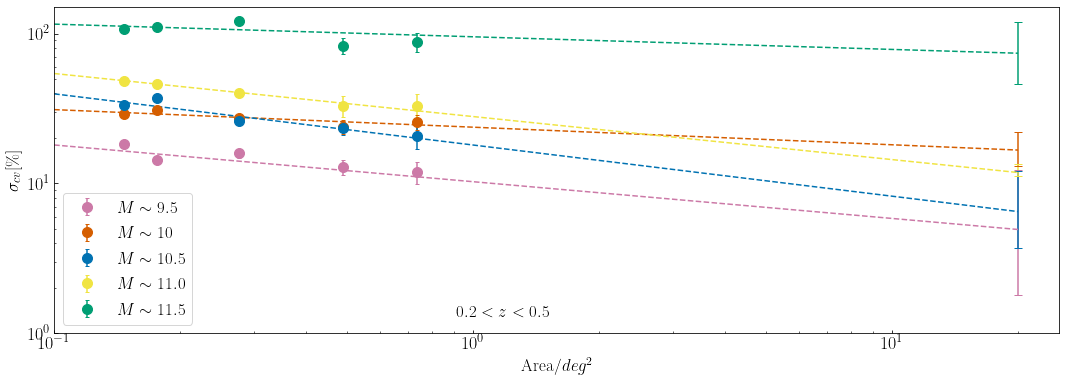

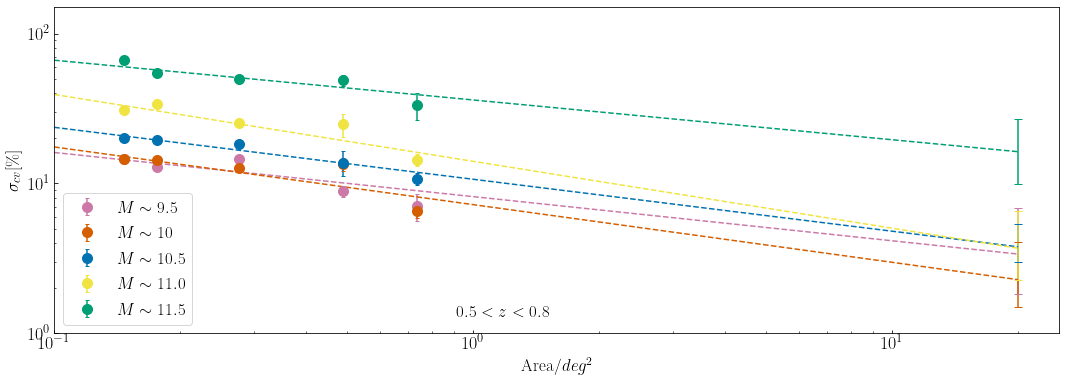

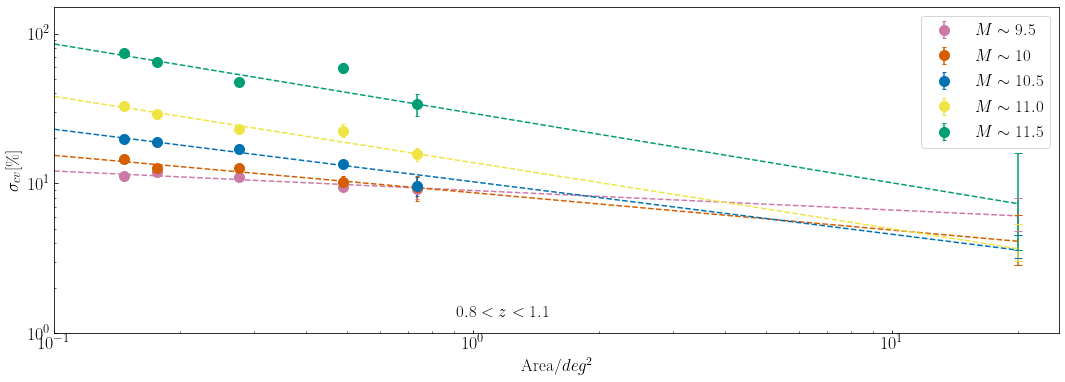

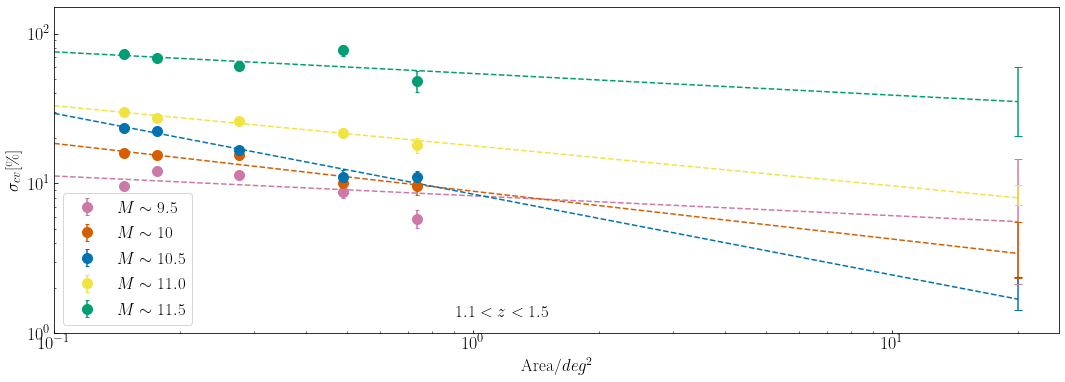

In [8]:
colors = ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00']
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_est_list = [9.5,10,10.5,11.0,11.5]
full_area = 20 # deg^2
for i in range(len(z_mins)): 
    fig, axs = plt.subplots(1, 1, figsize = (18, 6),sharex=True)
    cv_fullarea_list = []
    cv_fullarea_inf_list = []
    cv_fullarea_sup_list = []
    for k,mass in enumerate(mass_est_list):
        cv = []
        for patches in [6,9,16,25,30]:
            cv_1 = np.load('smf_cv/smf_cv2_all_'+str(z_mins[i])+'_'+str(z_maxs[i])+'_'+str(mass)+'_'+str(patches)+'.npy')
            if len(cv)==0:
                cv = cv_1
            else:
                cv = np.vstack([cv, cv_1])
        
        # measurements
        plt.errorbar(cv[:,0],cv[:,1]*100,yerr=((cv[:,1] - cv[:,2])*100,(cv[:,3] - cv[:,1])*100),fmt='o',color=colors[k], markersize=10, capsize=2,label='$M\sim '+str(mass)+'$')
        plt.xlim(0.1,25)
        plt.ylim(1,150)
        
        # fitting
        popt,pcov = curve_fit(power, cv[:,0], cv[:,1]*100, sigma = (cv[:,3] - cv[:,2])*100/2)
        arr = np.random.multivariate_normal(popt, pcov, 1000)
        cv_fullarea_samples = []
        for param in arr:
            cv_fullarea_samples.append(power(17,param[0],param[1]))
        
        cv_fullarea = np.median(cv_fullarea_samples,axis=0)
        cv_fullarea_inf = np.percentile(cv_fullarea_samples,16,axis=0)
        cv_fullarea_sup = np.percentile(cv_fullarea_samples,84,axis=0)
        cv_fullarea_list.append(cv_fullarea)
        cv_fullarea_inf_list.append(cv_fullarea_inf)
        cv_fullarea_sup_list.append(cv_fullarea_sup)
        
        # plot fitting
        x_plot = np.linspace(0.1,full_area,100)
        y_plot = power(x_plot,popt[0],popt[1])
        plt.plot(x_plot,y_plot,'--',color=colors[k])
        plt.errorbar(full_area,cv_fullarea,yerr=([cv_fullarea - cv_fullarea_inf],[cv_fullarea_sup-cv_fullarea]),capsize=4,color=colors[k])
    
    np.save('cosmic_variance/cv_'+str(z_mins[i])+'.npy',np.vstack([mass_est_list, cv_fullarea_list, cv_fullarea_inf_list, cv_fullarea_sup_list]))
    plt.annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.4,0.05]),xycoords='axes fraction',fontsize=17,color='k')
    plt.xlabel('Area/$deg^2$',fontsize=17)
    plt.ylabel('$\sigma_{cv}[\%]$',fontsize=17)
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize=17)
    plt.show()

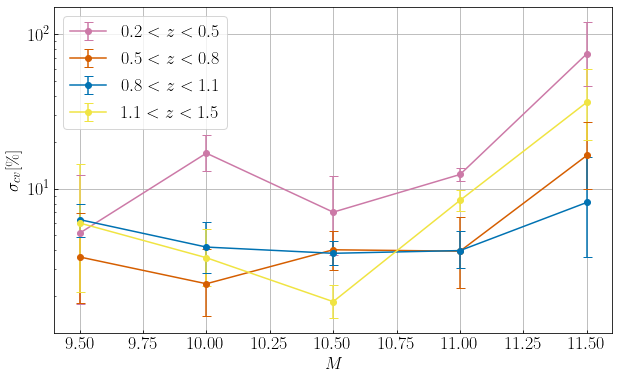

In [20]:
fig, axs = plt.subplots(1, 1, figsize = (10, 6),sharex=True)
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

colors = ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00']
for i in range(len(z_mins)): 
    cv_full_area = np.load('cosmic_variance/cv_'+str(z_mins[i])+'.npy')
    axs.errorbar(mass_est_list, cv_full_area[1,:], yerr=(cv_full_area[1,:]-cv_full_area[2,:],cv_full_area[3,:]-cv_full_area[1,:]), fmt='o-', capsize=4.5, color=colors[i],label='$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$')
    axs.set_xlabel('$M$',fontsize=17)
    axs.set_ylabel('$\sigma_{cv}[\%]$',fontsize=17)
    axs.set_yscale('log')
    axs.grid(True)
    axs.legend(fontsize=18)

#### Fitting Results

In [7]:
from scipy.spatial.distance import cdist
np.set_printoptions(precision=3)

In [45]:
# check difference between me and literature
# 0.8<z<1.1
num_bins = 50
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
zrange = '0.2_0.5'

smf = np.load('smf_nonir_all_'+zrange+'.npy')
x = bins[:-1]+bin_size/2
log_y = np.log10(smf[0])
x_interp = np.linspace(x[0],x[-1],100)
y_interp = np.interp(x_interp,x,log_y)
x_interp = x_interp[np.isfinite(y_interp)]
y_interp = y_interp[np.isfinite(y_interp)]
smf_interp = np.transpose(np.stack([x_interp,y_interp]))

# calculate distance to other curves
print('Distance to literature results at '+zrange+'\n')

# Weaver+22
smf_we =  np.load('smf_lit/smf_we_'+zrange+'.npy')
x_we = smf_we[:,0]
log_y_we = smf_we[:,1]
arr = cdist(smf_interp,smf_we)
print('Weaver+22',round(np.nanmean(np.nanmin(arr,axis=0)),3))

# Ilbert+13
smf_il =  np.load('smf_lit/smf_il_'+zrange+'.npy')
x_il = smf_il[:,0]
log_y_il = smf_il[:,1]
arr = cdist(smf_interp, smf_il)
print('Ilbert+13',round(np.nanmean(np.nanmin(arr,axis=0)),3))

# Davidzon+17
smf_da =  np.load('smf_lit/smf_da_'+zrange+'.npy')
x_da = smf_da[:,0]
log_y_da = smf_da[:,1]
arr = cdist(smf_interp,smf_da)
print('Davidzon+17',round(np.nanmean(np.nanmin(arr,axis=0)),3))

# Moutard+16
smf_mo =  np.load('smf_lit/smf_mo_'+zrange+'.npy')
x_mo = smf_mo[:,0]
log_y_mo = smf_mo[:,1]
arr = cdist(smf_interp, smf_mo)
print('Moutard+16',round(np.nanmean(np.nanmin(arr,axis=0)),3))


Distance to literature results at 0.2_0.5

Weaver+22 0.105
Ilbert+13 0.084
Davidzon+17 0.067
Moutard+16 0.077


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':


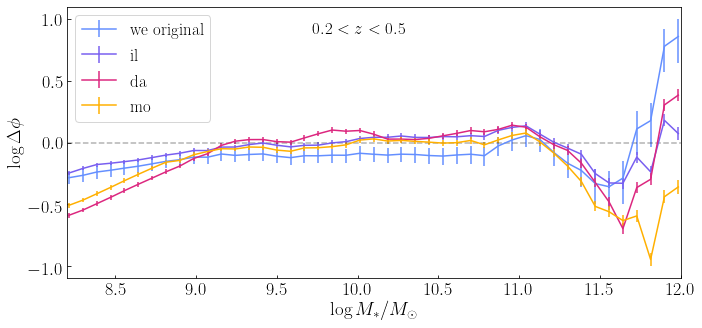

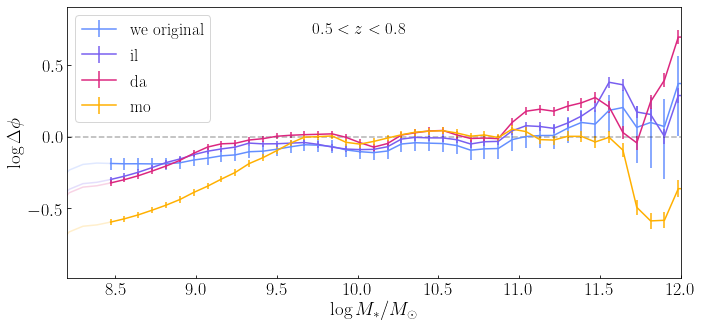

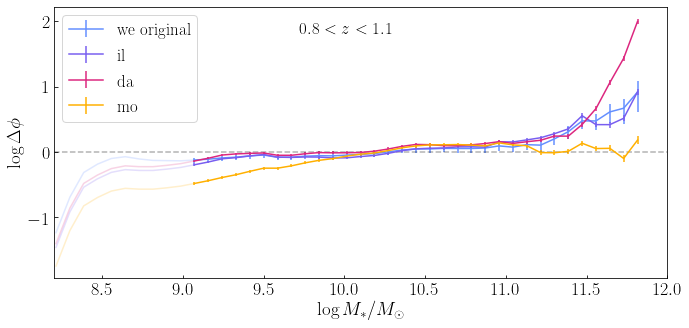

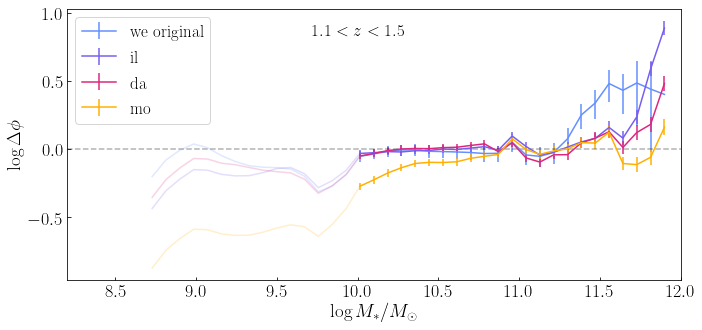

In [15]:
# calculate y-axis offset to other curves
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M")
lit_results = ['we_original','il','da','mo']
colors = ['#648FFF','#785EF0','#DC267F','#FFB000']

z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
for z_idx in range(len(z_mins)):
    smf_myrun = np.load('smf_nonir_all_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.npy')
    x_myrun = bins[:-1]+bin_size/2
    log_y_myrun = np.log10(smf_myrun[0])
    log_yerr_myrun_plus = smf_myrun[1]
    log_yerr_myrun_minus = smf_myrun[2]

    fig, axs = plt.subplots(1, 1, figsize = (11, 5))
    for k,lit in enumerate(lit_results):
        smf_lit = np.load('smf_lit/smf_'+lit+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.npy')
        x_lit = smf_lit[:,0]
        log_y_lit = smf_lit[:,1]
        
        if lit == 'we_original':
            log_yerr_lit_minus = smf_lit[:,2]
            log_yerr_lit_plus = smf_lit[:,3]
        else:
            log_yerr_lit_minus = smf_lit[:,1]/100
            log_yerr_lit_plus = smf_lit[:,1]/100
            
        log_yerr_lit_minus_interp = np.interp(x_myrun, x_lit, log_yerr_lit_minus)
        log_yerr_lit_plus_interp = np.interp(x_myrun, x_lit, log_yerr_lit_plus)
        log_yerr_minus_interp = np.sqrt(log_yerr_lit_minus_interp**2+log_yerr_myrun_minus**2)
        log_yerr_plus_interp = np.sqrt(log_yerr_lit_plus_interp**2+log_yerr_myrun_plus**2)

        log_y_lit_interp = np.interp(x_myrun, x_lit, log_y_lit)
        offset = log_y_lit_interp - log_y_myrun 
        
        comp_limit_index = bisect(bins, mass_comp_80[z_idx])
        plt.plot(x_myrun[:comp_limit_index],offset[:comp_limit_index],alpha=0.2,color=colors[k])
        plt.errorbar(x_myrun[comp_limit_index-1:],offset[comp_limit_index-1:],yerr=(log_yerr_minus_interp[comp_limit_index-1:],log_yerr_plus_interp[comp_limit_index-1:]),label=lit.replace('_',' '),color=colors[k])

    plt.hlines(y=0,xmin=8.2,xmax=12.,ls='dashed',alpha=0.3)
    plt.legend(fontsize=17)
    #plt.title('fields='+cat_type+', '+phot_config+', z-outlier corr='+str(z_outlier_corr)+', comp corr='+str(comp_corr)+', mass corr='+str(mass_offset_flag)+'\n'+time,fontsize=18)
    plt.annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.4,0.9]),xycoords='axes fraction',fontsize=17,color='k')
    plt.xlim(8.2,12.)
    plt.xlabel('$\log M_*/M_\odot$',fontsize=19)
    plt.ylabel('$\log\Delta\phi$',fontsize=19)
    

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle sepa

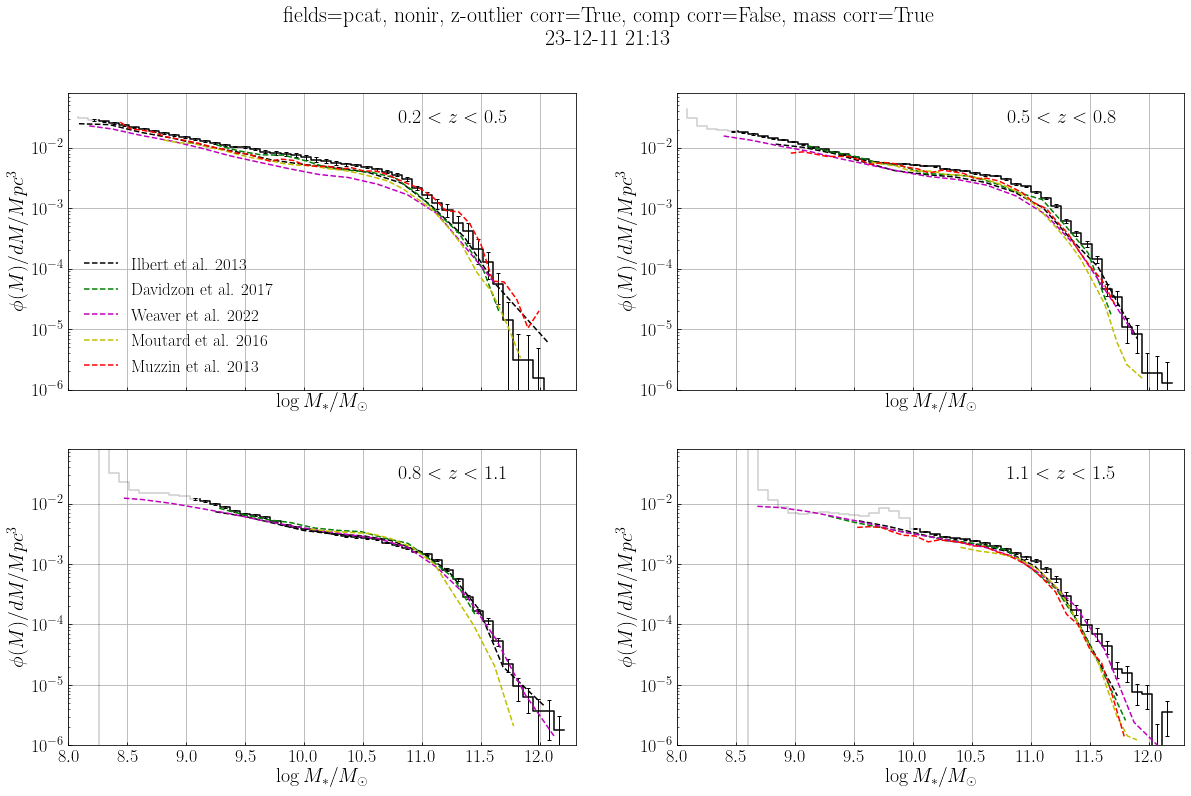

In [19]:
# plot
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M")
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
plt.suptitle('fields='+cat_type+', '+phot_config+', z-outlier corr='+str(z_outlier_corr)+', comp corr='+str(comp_corr)+', mass corr='+str(mass_offset_flag)+'\n'+time,fontsize=22)

if z_bins == 'original':
    z_mins = [0.2, 0.5, 0.8, 1.1]
    z_maxs = [0.5, 0.8, 1.1, 1.5]
else: #'alt'
    z_mins = [0.2, 0.35, 0.7, 0.9]
    z_maxs = [0.35, 0.7, 0.9, 1.1]
    
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
sigma_ms = [0.25,0.2,0.2,0.2]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
cat_comp = Table.read('comp_sigmoid_params.fits')

sfq='all'
fit_const_sigma = False
show_fit = False
show_lit = True
for i in range(len(z_mins)):       
    row = i//2
    col = i%2
    
    # load smf data 
    smf = np.load('smf_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
    x = bins[:-1]+bin_size/2
    y = smf[0]
    yerr_plus = smf[1]
    yerr_minus = smf[2]
        
    # the plot
    comp_limit_index = bisect(bins, mass_comp_80[i])
    axs[row][col].plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],ls='steps',color='k',alpha=0.2)
    axs[row][col].plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],ls='steps',color='k')
    axs[row][col].errorbar(bins[comp_limit_index-1:-1]+bin_size/2, y[comp_limit_index-1:], yerr=(yerr_minus[comp_limit_index-1:],yerr_plus[comp_limit_index-1:]) , color='k',linewidth=1,capsize=2,linestyle='')
    
    # Literature Results
    if z_bins == 'original' and show_lit == True:
        # compare to ilbert+2013 results
        smf_il =  np.load('smf_lit/smf_il_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_il[:,0],10**smf_il[:,1],'--',color='k',label='Ilbert et al. 2013')
        
        # compare to Davidzon+2017 results
        smf_da =  np.load('smf_lit/smf_da_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_da[:,0],10**smf_da[:,1],'--',color='g',label='Davidzon et al. 2017')
        
        # compare to Weaver+2022 results
        smf_we =  np.load('smf_lit/smf_we_original_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_we[:,0],10**smf_we[:,1],'--',color='m',label='Weaver et al. 2022')
        
        # compare to moutard+2016 results
        smf_mo =  np.load('smf_lit/smf_mo_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        axs[row][col].plot(smf_mo[:,0],10**smf_mo[:,1],'--',color='y',label='Moutard et al. 2016')
    
    #fitting results
    if show_fit:
        x_plot = np.linspace(8,12.5,100)
        if fit_const_sigma:
            popt = np.load('fit_param_dsi_'+sfq+'.npy')[i]
            axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color='b',alpha=0.5)
            axs[row][col].plot(x_plot,con_double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),color='b',alpha=0.5)
        else:
            popt = np.load('fit_param_varysigma_'+sfq+'.npy')[i]
            axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color='b',alpha=0.5)
            axs[row][col].plot(x_plot,con_double_schec_varysigma(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),color='b',alpha=0.5)
    
        # popt = np.load('fit_param_dsi_'+sfq+'.npy')[i]
        # axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color='b',alpha=0.5)
    
    axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    axs[row][col].set_yscale('log')
    axs[row][col].set_xlim([8,12.3])
    axs[row][col].set_ylim([1e-6,8e-2])
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.65,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].grid(True)

if z_bins == 'original' and show_lit == True:
    smf_mu =  np.load('smf_lit/smf_mu_0.2_0.5.npy')
    axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
    smf_mu =  np.load('smf_lit/smf_mu_0.5_1.0.npy')
    axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
    
    smf_mu =  np.load('smf_lit/smf_mu_1.0_1.5.npy')
    axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'--',color='r',label='Muzzin et al. 2013')
    axs[0][0].legend(fontsize=17,frameon=False)

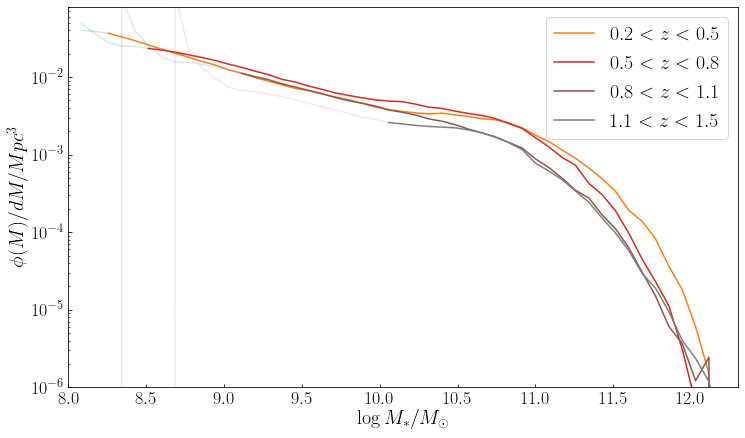

In [13]:
# overplot SMF from all bins
fig, axs = plt.subplots(1, 1, figsize = (12, 7))
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
sigma_ms = [0.25,0.2,0.2,0.2]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
cat_comp = Table.read('comp_sigmoid_params.fits')
phot_config = 'nonirirac'

for i in range(len(z_mins)):       
    # load smf data
    smf = np.load('smf_'+phot_config+'_all_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
    x = bins[:-1]+bin_size/2
    y = smf[0]
    yerr_plus = smf[1]
    yerr_minus = smf[2]
    
    # the plot
    comp_limit_index = bisect(bins, mass_comp_80[i])
    plt.plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],alpha=0.2)
    plt.plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],label='$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$')
    # plt.errorbar(bins[comp_limit_index-1:-1]+bin_size/2, y[comp_limit_index-1:], yerr=(yerr_minus[comp_limit_index-1:],yerr_plus[comp_limit_index-1:]) , color='k',linewidth=1,capsize=2,linestyle='')
    
    plt.xlabel('$\log M_*/M_\odot$',fontsize=20)
    plt.ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    plt.yscale('log')
    plt.xlim([8,12.3])
    plt.ylim([1e-6,8e-2])
    plt.legend(fontsize=20)

#### All Fields
COSMOS DEEP ELAIS

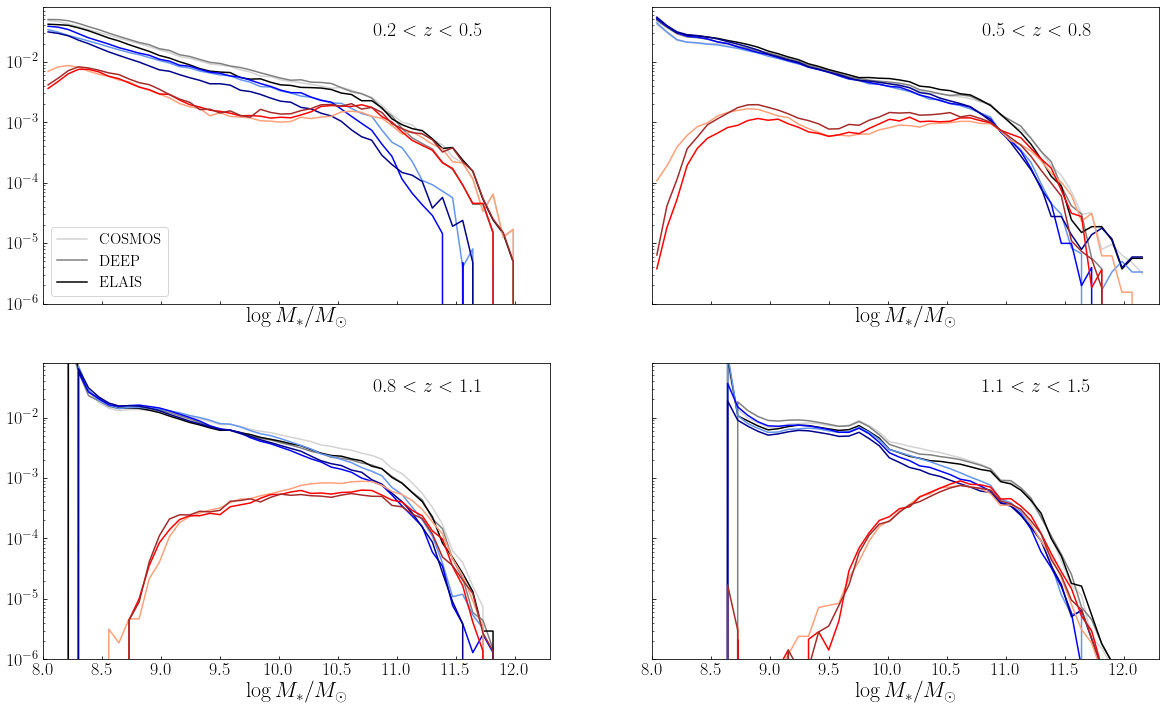

In [27]:
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True,sharey=True)
# plt.suptitle('fields='+cat_type+', '+phot_config+', z-outlier corr='+str(z_outlier_corr)+', comp corr='+str(comp_corr)+', mass corr='+str(mass_offset_flag)+'\n'+time,fontsize=22)

z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
areas = [area, area_deep,area_elais]
num_bins=50
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]

q_colors = ['lightsalmon','red','brown']
sf_colors = ['cornflowerblue','blue','darkblue']
all_colors  = ['lightgray','gray','black']
phot_config = 'nonir'
for i,z_min in enumerate(z_mins):
    row = i//2
    col = i%2
    for sfq in ['all','sf','q']:
        for k, cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
            smf = np.load('smf_'+cat_name+'_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        
            # plot data
            x = bins[:-1]+np.diff(bins)/2
            y = smf[0]
            
            if sfq == 'sf':
                axs[row][col].plot(bins[:-1]+bin_size/2,y,color=sf_colors[k])
            elif sfq == 'q':
                axs[row][col].plot(bins[:-1]+bin_size/2,y,color=q_colors[k])
            else:
                axs[row][col].plot(bins[:-1]+bin_size/2,y,label=cat_name.replace('_deep',''),color=all_colors[k])
                
    axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.65,0.9]),xycoords='axes fraction',fontsize=20,color='k')
    axs[row][col].set_yscale('log')
    axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=22)
    axs[row][col].set_xlim([8,12.3])
    axs[row][col].set_ylim([1e-6,8e-2])
    axs[0][0].legend(fontsize=15,loc='lower left')    
    

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in subtract
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


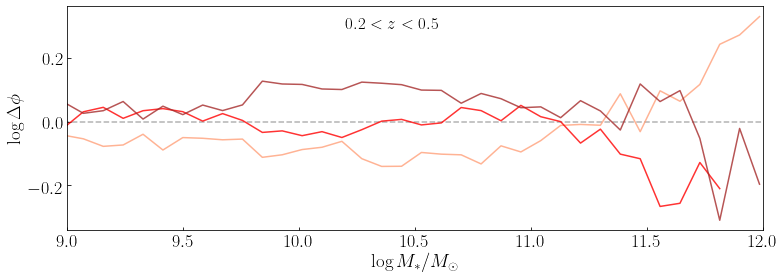

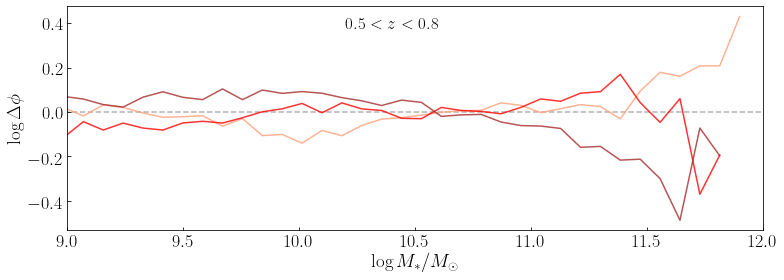

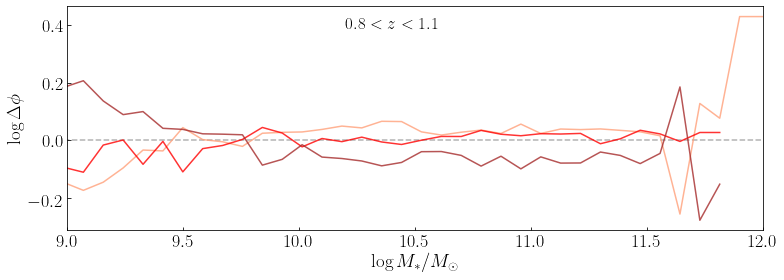

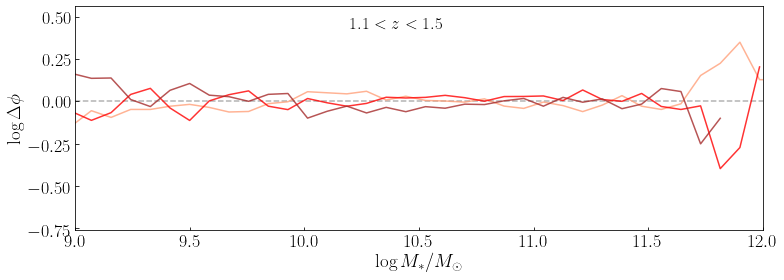

In [45]:
# calculate y-axis offset to other curves
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M")
cat_names = ['COSMOS_deep','DEEP_deep','ELAIS_deep']
colors = ['lightsalmon','red','brown']

z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
for z_idx in range(len(z_mins)):
    smf_all = np.load('smf_'+phot_config+'_q_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.npy')
    x_all = bins[:-1]+bin_size/2
    log_y_all = np.log10(smf_all[0])

    fig, axs = plt.subplots(1, 1, figsize = (11, 4))
    for k,cat_name in enumerate(cat_names):
        smf_field = np.load('smf_'+cat_name+'_'+phot_config+'_'+sfq+'_'+str(z_mins[z_idx])+'_'+str(z_maxs[z_idx])+'.npy')
        log_y_field = np.log10(smf_field[0])
        offset = log_y_field - log_y_all
        plt.plot(x_all, offset, alpha=0.8,color=colors[k])

    plt.hlines(y=0,xmin=8.2,xmax=12.,ls='dashed',alpha=0.3)
    plt.annotate('$'+str(z_mins[z_idx])+'<z<'+str(z_maxs[z_idx])+'$',xy=([0.4,0.9]),xycoords='axes fraction',fontsize=17,color='k')
    plt.xlim(9,12.0)
    plt.xlabel('$\log M_*/M_\odot$',fontsize=19)
    plt.ylabel('$\log\Delta\phi$',fontsize=19)
    plt.tight_layout()


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle sepa

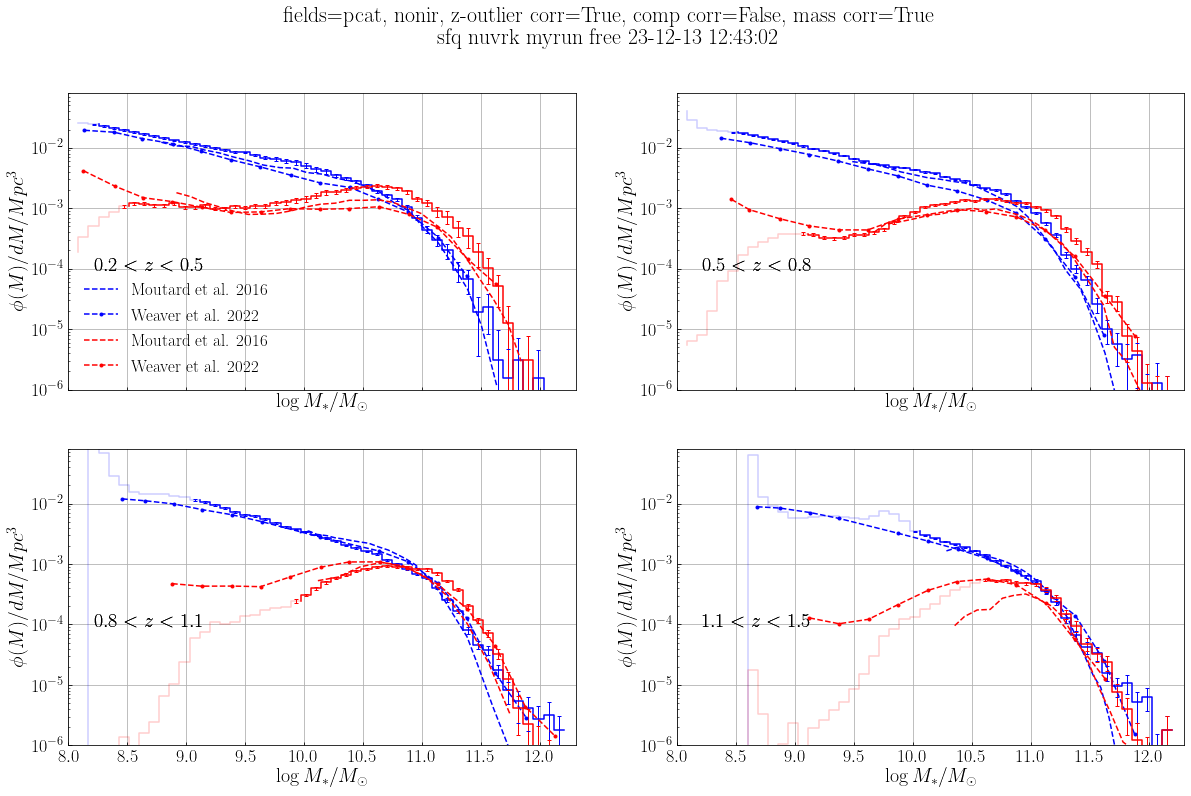

In [23]:
time = datetime.now()
time = time.strftime("%y-%m-%d %H:%M:%S")

z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]
mass_shift = [0.04, 0.05, 0.07, 0.08]
mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]
fit_start_shift = [2,2,0,-5]
end_point = [-3,-3,-6,-3]
sigma_ms = [0.25,0.2,0.2,0.2]
num_bins = 50 # number of bin edges
bins = np.linspace(8,12.2,num_bins)
bin_size = bins[1]-bins[0]
cat_comp = Table.read('comp_sigmoid_params.fits')

phot_config = 'nonir'
fit_params = []
fit_params_err = []
show_fit = False
show_lit = True

# plot
fig, axs = plt.subplots(2, 2, figsize = (20, 12),sharex=True)
plt.suptitle('fields='+cat_type.replace('_',' ')+', '+phot_config+', z-outlier corr='+str(z_outlier_corr)+', comp corr='+str(comp_corr)+', mass corr='+str(mass_offset_flag)+'\n'+sfq_keyname.replace('_',' ')+' '+time+'',fontsize=22)
for i in range(len(z_mins)):       
    row = i//2
    col = i%2
    colors = ['b','r']
    for k,sfq in enumerate(['sf','q']):
        smf = np.load('smf_'+phot_config+'_'+sfq+'_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
        x = bins[:-1]+bin_size/2
        y = smf[0]
        yerr_plus = smf[1]
        yerr_minus = smf[2]
        
        if sfq=='sf':
            comp_limit_index = bisect(bins, mass_comp_sf_80[i])
        else:
            comp_limit_index = bisect(bins, mass_comp_q_80[i])
        axs[row][col].plot(bins[:comp_limit_index]+bin_size,y[:comp_limit_index],ls='steps',color=colors[k],alpha=0.2)
        axs[row][col].plot(bins[comp_limit_index-1:-1]+bin_size,y[comp_limit_index-1:],ls='steps',color=colors[k])
        axs[row][col].errorbar(bins[comp_limit_index-1:-1]+bin_size/2, y[comp_limit_index-1:], yerr=(yerr_minus[comp_limit_index-1:],yerr_plus[comp_limit_index-1:]) , color=colors[k],linewidth=1,capsize=2,linestyle='')
        
        #compare to moutard+2016 results
        if show_lit:
            if sfq =='sf':
                smf_mo =  np.load('smf_lit/smf_mo_sf_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
                axs[row][col].plot(smf_mo[:,0],10**smf_mo[:,1],'--',color='b',label='Moutard et al. 2016')
            else:
                smf_mo =  np.load('smf_lit/smf_mo_q_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
                axs[row][col].plot(smf_mo[:,0],10**smf_mo[:,1],'--',color='r',label='Moutard et al. 2016')         
        
            # compare to Weaver+2022 results
            if sfq =='sf':
                smf_we =  np.load('smf_lit/smf_we_sf_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
                axs[row][col].plot(smf_we[:,0],10**smf_we[:,1],'.--',color='b',label='Weaver et al. 2022')
            else:
                smf_we =  np.load('smf_lit/smf_we_q_'+str(z_mins[i])+'_'+str(z_maxs[i])+'.npy')
                axs[row][col].plot(smf_we[:,0],10**smf_we[:,1],'.--',color='r',label='Weaver et al. 2022')           
        
        if show_fit:# fit with model
            x_plot = np.linspace(8,12.5,100)
            if fit_const_sigma:
                popt = np.load('fit_param_dsi_'+sfq+'.npy')[i]
                axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),colors[k],alpha=0.5)
                axs[row][col].plot(x_plot,con_double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),colors[k],alpha=0.5)
            else:
                popt = np.load('fit_param_varysigma_'+sfq+'.npy')[i]
                axs[row][col].plot(x_plot,double_schechter(x_plot,popt[0] ,popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),colors[k],alpha=0.5)
                axs[row][col].plot(x_plot,con_double_schec_varysigma(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5]),colors[k],alpha=0.5)
    
        axs[row][col].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
        axs[row][col].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
        axs[row][col].set_yscale('log')
        axs[row][col].set_xlim([8,12.3])
        axs[row][col].set_ylim([1e-6,8e-2])
        axs[row][col].annotate('$'+str(z_mins[i])+'<z<'+str(z_maxs[i])+'$',xy=([0.05,0.4]),xycoords='axes fraction',fontsize=20,color='k')
        axs[row][col].grid(True)
        
# if show_lit:
#Muzzin+2013
#     smf_mu =  np.load('smf_mu_sf_0.2_0.5.npy')
#     axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b',label='Muzzin et al. 2013')
#     smf_mu =  np.load('smf_mu_sf_0.5_1.0.npy')
#     axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b')
#     smf_mu =  np.load('smf_mu_sf_1.0_1.5.npy')
#     axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='b')
    
#     smf_mu =  np.load('smf_mu_q_0.2_0.5.npy')
#     axs[0][0].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
#     smf_mu =  np.load('smf_mu_q_0.5_1.0.npy')
#     axs[0][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')
#     smf_mu =  np.load('smf_mu_q_1.0_1.5.npy')
#     axs[1][1].plot(smf_mu[:,0],10**smf_mu[:,1],'.-',color='r')

axs[0][0].legend(fontsize=17,frameon=False)

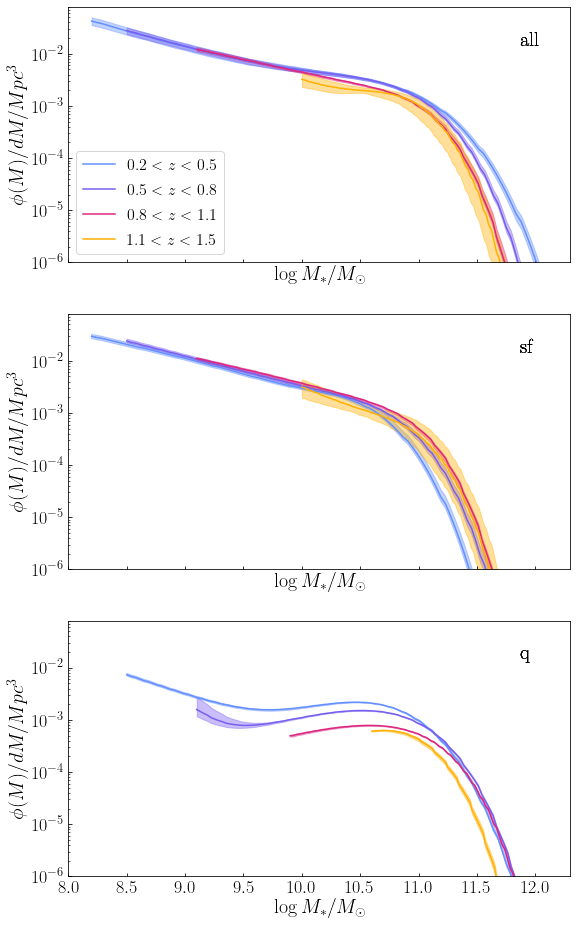

In [75]:
# evolution of SMF (fit)
colors = ['#648FFF','#785EF0','#DC267F','#FFB000']
fig, axs = plt.subplots(3, 1, figsize = (9,16),sharex=True)
mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]
fit_const_sigma = False

for i,sfq in enumerate(['all','sf','q']):
    if fit_const_sigma:
        fit_params = np.load('fit_param_dsi_'+sfq+'.npy')
        fit_params_err = np.load('fit_param_err_dsi_'+sfq+'.npy')
    else:
        fit_params = np.load('fit_param_varysigma_'+sfq+'.npy')
        fit_params_err = np.load('fit_param_err_varysigma_'+sfq+'.npy')
    
    for k in [0,1,2,3]:  # redshift bin number
        # smf = np.load('smf_'+sfq+'_'+str(z_mins[k])+'_'+str(z_maxs[k])+'.npy')
        # y = smf[0]
        # yerr_plus = smf[1]
        # yerr_minus = smf[2]
    
        y_list = []
        if sfq =='sf':
            x_plot = np.linspace(mass_comp_sf_80[k],12.2,100)
        elif sfq == 'q':
            x_plot = np.linspace(mass_comp_q_80[k],12.2,100)
        else:
            x_plot = np.linspace(mass_comp_80[k],12.2,100)
        
        for j in range(30):
            if sfq =='q':
                err_factor = 0.3
            else:
                err_factor = 1
            popt_j = fit_params[k] + (np.random.rand(6)-0.5)*2*err_factor*fit_params_err[k]
            if fit_const_sigma:
                y = con_double_schechter(x_plot, popt_j[0], popt_j[1]/1e3, popt_j[2],popt_j[3]/1e3, popt_j[4],popt_j[5])
            else:
                y = con_double_schec_varysigma(x_plot, popt_j[0], popt_j[1]/1e3, popt_j[2],popt_j[3]/1e3, popt_j[4],z_mins[k])
            y_list.append(y)
        
        y_median = np.median(y_list,axis=0)
        y_16 = np.percentile(y_list,16,axis=0)
        y_84 = np.percentile(y_list,84,axis=0)
    
        popt = fit_params[k]
        # axs[i].plot(x_plot, double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4]),color = colors[k],label='$'+str(z_mins[k])+'<z_{myrun}<'+str(z_maxs[k])+'$')
        if fit_const_sigma:
            y_plot = con_double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],popt[5])
            # y_plot = double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4])
            axs[i].plot(x_plot, y_plot, color = colors[k],label='$'+str(z_mins[k])+'<z<'+str(z_maxs[k])+'$')
        else:
            y_plot = con_double_schec_varysigma(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4],z_mins[k])
            # y_plot = double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4])
            axs[i].plot(x_plot, y_plot,color = colors[k],label='$'+str(z_mins[k])+'<z<'+str(z_maxs[k])+'$')
        axs[i].fill_between(x_plot,y_16,y_84,color = colors[k],alpha=0.4)
        
        axs[i].annotate(sfq,xy=([0.9,0.85]),xycoords='axes fraction',fontsize=20,color='k')
    
    axs[i].set_xlabel('$\log M_*/M_\odot$',fontsize=20)
    axs[i].set_ylabel('$\phi(M)/dM/Mpc^3$',fontsize=20)
    axs[i].set_yscale('log')
    axs[i].set_xlim([8,12.3])
    axs[i].set_ylim([1e-6,8e-2])

axs[0].legend(fontsize=16)


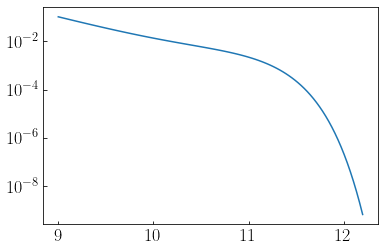

In [82]:
fit_params = np.load('fit_param_varysigma_all.npy')
popt = [11,5,0,1,-1,0.2]
x_plot = np.linspace(9,12.2,100)
y_plot = double_schechter(x_plot, popt[0], popt[1]/1e3, popt[2],popt[3]/1e3, popt[4])

plt.plot(x_plot,y_plot)
plt.yscale('log')

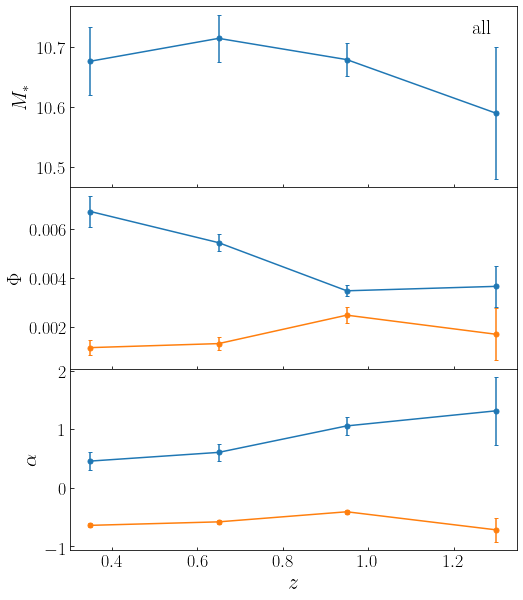

In [181]:
fig, axs = plt.subplots(3, 1, figsize = (8, 10),sharex=True)

sfq='all'
fit_const_sigma = False
if fit_const_sigma:
    fit_params = np.load('fit_param_dsi_'+sfq+'.npy')
    fit_params_err = np.load('fit_param_err_dsi_'+sfq+'.npy')
else:
    fit_params = np.load('fit_param_varysigma_'+sfq+'.npy')
    fit_params_err = np.load('fit_param_err_varysigma_'+sfq+'.npy')
        
phi1_list = []
phi2_list = []
alpha1_list = []
alpha2_list = []
ms_list = []
phi1_err_list = []
phi2_err_list = []
alpha1_err_list = []
alpha2_err_list = []
ms_err_list = []
z_mins = [0.2, 0.5, 0.8, 1.1]
z_maxs = [0.5, 0.8, 1.1, 1.5]

 # m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
for i in range(4): # 4 z-bins
    if fit_params[i][1] > fit_params[i][3]:
        phi1_list.append(fit_params[i][1]/1e3)
        phi2_list.append(fit_params[i][3]/1e3)
        alpha1_list.append(fit_params[i][2])
        alpha2_list.append(fit_params[i][4])
        phi1_err_list.append(fit_params_err[i][1]/1e3)
        phi2_err_list.append(fit_params_err[i][3]/1e3)
        alpha1_err_list.append(fit_params_err[i][2])
        alpha2_err_list.append(fit_params_err[i][4])
    else:
        phi1_list.append(fit_params[i][3]/1e3)
        phi2_list.append(fit_params[i][1]/1e3)
        alpha1_list.append(fit_params[i][4])
        alpha2_list.append(fit_params[i][2])
        phi1_err_list.append(fit_params_err[i][3]/1e3)
        phi2_err_list.append(fit_params_err[i][1]/1e3)
        alpha1_err_list.append(fit_params_err[i][4])
        alpha2_err_list.append(fit_params_err[i][2])

    ms_list.append(fit_params[i][0])
    ms_err_list.append(fit_params_err[i][0])
    
    
axs[0].errorbar((np.array(z_maxs)+np.array(z_mins))/2,ms_list, yerr=ms_err_list, fmt='.-',capsize=2,markersize=10)
axs[1].errorbar((np.array(z_maxs)+np.array(z_mins))/2,phi1_list, yerr=phi1_err_list, fmt='.-',capsize=2,markersize=10)
axs[1].errorbar((np.array(z_maxs)+np.array(z_mins))/2,phi2_list, yerr=phi2_err_list, fmt='.-',capsize=2,markersize=10)
axs[2].errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha1_list, yerr=alpha1_err_list, fmt='.-',capsize=2,markersize=10)
axs[2].errorbar((np.array(z_maxs)+np.array(z_mins))/2,alpha2_list, yerr=alpha2_err_list, fmt='.-',capsize=2,markersize=10)
axs[0].annotate(sfq,xy=([0.9,0.85]),xycoords='axes fraction',fontsize=20,color='k')

axs[2].set_xlabel(r'$z$',fontsize=22)
axs[0].set_ylabel(r'$M_*$',fontsize=20)
axs[1].set_ylabel(r'$\Phi$',fontsize=20)
axs[2].set_ylabel(r'$\alpha$',fontsize=21)
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

In [56]:
np.load('fit_param_varysigma_'+sfq+'.npy')

ValueError: Object arrays cannot be loaded when allow_pickle=False

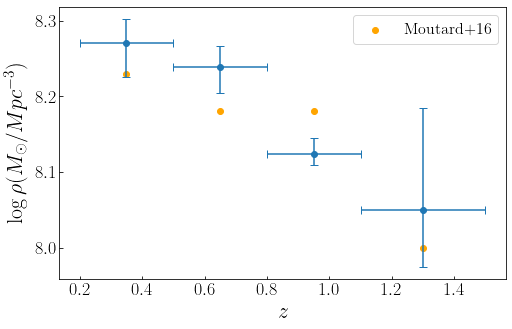

In [66]:
# mass density evolution plot
z_mins = np.array([0.2, 0.5, 0.8, 1.1])
z_maxs = np.array([0.5, 0.8, 1.1, 1.5])
mass_comp_80 = [8.2, 8.5, 9.1, 10]
mass_comp_sf_80 = [8.2, 8.5, 9.1, 10.]
mass_comp_q_80 = [8.5, 9.1, 9.9, 10.6]

sfq='all'
fit_const_sigma = False
if fit_const_sigma:
    fit_params = np.load('fit_param_dsi_'+sfq+'.npy')
    fit_params_err = np.load('fit_param_err_dsi_'+sfq+'.npy')
else:
    fit_params = np.load('fit_param_varysigma_'+sfq+'.npy', allow_pickle=True)
    fit_params_err = np.load('fit_param_err_varysigma_'+sfq+'.npy', allow_pickle=True)

cat_comp = Table.read('comp_sigmoid_params.fits')

rho_star = []
rho_star_16 = []
rho_star_84 = []
m_lower = 9.2
m_higher = 12.5
step = 0.01
for i in range(4): # 4 z-bins
    ms = fit_params[i][0]
    phi1 = fit_params[i][1]/1e3
    phi2 = fit_params[i][3]/1e3
    alpha1 = fit_params[i][2]
    alpha2 = fit_params[i][4]
    
    alpha1_lowz = fit_params[0][2]
    alpha2_lowz = fit_params[0][4]
    
    if sfq =='sf':
        m_limit = mass_comp_sf_80[i]
    elif sfq == 'q':
        m_limit = mass_comp_q_80[i]
    else:
        m_limit = mass_comp_80[i]
    
    # mass density
    total_mass = 0
    factor = double_schechter(m_limit, ms,phi1,alpha1,phi2,alpha2)*step*10**(m_limit-8) / double_schechter(m_limit, ms,phi1,alpha1_lowz,phi2,alpha2_lowz)*step*10**(m_limit-8) # normalization factor to use a general alpha at low mass
    for m in np.arange(m_lower,m_higher,step):
        if m > m_limit:
            total_mass += double_schechter(m, ms,phi1,alpha1,phi2,alpha2)*step*10**(m-8)
        else:
            total_mass += double_schechter(m, ms,phi1,alpha1_lowz,phi2,alpha2_lowz)*step*10**(m-8) * factor
    rho_star.append(np.log10(total_mass)+8)
    
    # calculate uncertainty
    total_mass_js = []
    for j in range(50):
        popt_j = fit_params[i] + (np.random.rand(6)-0.5)*2*fit_params_err[i]
        
        ms_j = popt_j[0]
        phi1_j = popt_j[1]/1e3
        phi2_j = popt_j[3]/1e3
        alpha1_j = popt_j[2]
        alpha2_j = popt_j[4]
        
        total_mass_j = 0
        for m in np.arange(m_lower,m_higher,step):
            if m > m_limit:
                total_mass_j += double_schechter(m, ms_j,phi1_j,alpha1_j,phi2_j,alpha2_j)*step*10**(m-8)
            else:
                total_mass_j += double_schechter(m, ms_j,phi1_j,alpha1_lowz,phi2_j,alpha2_lowz)*step*10**(m-8) * factor
                
        total_mass_js.append(total_mass_j)
        
    rho_star_16.append(np.log10(np.percentile(total_mass_js,16))+8)
    rho_star_84.append(np.log10(np.percentile(total_mass_js,84))+8)

rho_star = np.array(rho_star)
rho_star_16 = np.array(rho_star_16)
rho_star_84 = np.array(rho_star_84)

fig, axs = plt.subplots(1, 1, figsize = (8, 5),sharex=True)
axs.errorbar((z_mins+z_maxs)/2,rho_star,xerr=(z_maxs-z_mins)/2 ,yerr=(rho_star-rho_star_16, rho_star_84-rho_star),fmt='o',capsize=4)
axs.set_xlabel(r'$z$',fontsize=22)
axs.set_ylabel(r'$\log\rho (M_\odot/Mpc^{-3})$',fontsize=22)

# Moutard+2016
axs.scatter((z_mins+z_maxs)/2, [8.23,8.18,8.18,8.00],color='orange',label='Moutard+16')
axs.legend(fontsize=16)

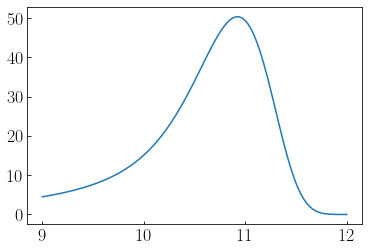

In [74]:
m = np.linspace(9,12,100)

plt.plot(m, double_schechter(m, 10.8,5.859,0.457,1.06,-0.629)*0.03*10**(m-8))

#### schecter function fit

In [13]:
from scipy.optimize import curve_fit
from bisect import bisect

# schecter function
def schechter(log_m,phi,log_m_s,alpha_s):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return phi*(m/m_s)**(alpha_s)*np.exp(-(m/m_s))

def double_schechter(log_m,log_m_s,phi1,alpha_s1,phi2,alpha_s2):
    m_s = 10**(log_m_s-10)
    m = 10**(log_m-10)
    return (phi1*(m/m_s)**(alpha_s1)+phi2*(m/m_s)**(alpha_s2))*np.exp(-(m/m_s))

def con_double_schec_varysigma(masses,m_s,phi1,alpha_s1,phi2,alpha_s2,z_min):
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    z_min = round(z_min,1)
    arr = np.load('mass_err/mass_err_overall_all_'+str(z_min)+'.npy')
    mass_err_x = arr[0]
    mass_err_y = arr[1]

    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        con_values = []
        for m in masses:
            sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
            kernel = []  # the gaussian kernel
            for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
                kernel.append(gaussian(i*dx,0,sigma_m_var))
            kernel = np.array(kernel)
            kernel  = kernel / sum(kernel)
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        m = masses
        sigma_m_var = np.interp(m,mass_err_x,mass_err_y)
        kernel = []
        for i in range(int(-3*sigma_m_var/dx),int(3*sigma_m_var/dx)+1):
            kernel.append(gaussian(i*dx,0,sigma_m_var))
        kernel = np.array(kernel)
        kernel  = kernel / sum(kernel)
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
    
    return np.array(con_values)
        
def con_double_schechter(masses,m_s,phi1,alpha_s1,phi2,alpha_s2, sigma_m): # convolved schecter function with a gaussian function
    intervals = 300
    mrange = np.linspace(8, 12.2, intervals)
    dx = (12.2-8)/intervals
    values = double_schechter(mrange+dx/2,m_s,phi1,alpha_s1,phi2,alpha_s2)  # un-convolved values 
    
    # the gaussian kernel (same sigma_m for all masses)
    kernel_const = []
    con_values = []
    for i in range(int(-3*sigma_m/dx),int(3*sigma_m/dx)+1):
        kernel_const.append(gaussian(i*dx,0,sigma_m))
    kernel_const = np.array(kernel_const)
    kernel_const  = kernel_const / sum(kernel_const)
    
    # calculate convolved values
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel_const,mode='same')[min(bisect(mrange, m),intervals-1)])
    elif isinstance(masses, float):
        con_values = np.convolve(values, kernel_const, mode='same')[min(bisect(mrange, m),intervals-1)]  
    else:
        raise ValueError("wrong value for mass...")
        
    return np.array(con_values)


def con_schechter(masses,phi,m_s,alpha_s,sigma): # convolved schecter function with a gaussian function
    intervals = 300
    dx = (12.2-8)/intervals
    
    # the gaussian kernel
    kernel = []
    for i in range(int(-3*sigma/dx),int(3*sigma/dx)+1):
        kernel.append(gaussian(i*dx,0,sigma))
    kernel = np.array(kernel)
    kernel  = kernel / sum(kernel)
    
    # calculate convolved values
    con_values = []
    mrange = np.linspace(8, 12.2, intervals)
    values = schechter(mrange+dx/2,phi,m_s,alpha_s)   
    if isinstance(masses, list) or isinstance(masses, np.ndarray):
        for m in masses:
            con_values.append(np.convolve(values,kernel,mode='same')[min(bisect(mrange, m),intervals-1)])
    else:
        m = masses 
        con_values = np.convolve(values, kernel, mode='same')[min(bisect(mrange, m),intervals-1)]           
    return np.array(con_values)

def gaussian(x, mu, sig):
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


In [14]:
# fitting schecter function
def fit_schechter(xdata, ydata, ydata_err, start, end): # phi,m_s,alpha
    popt,pcov = curve_fit(schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.2e+04,-1.75])
    res = ydata - schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m): # phi,m_s,alpha,sigma_m
    popt,pcov = curve_fit(con_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[2e-4,2.1e+01,-1.5,sigma_m],bounds=([0,1e3,-2,sigma_m-0.00000001],[1e-2,1e5,2,sigma_m]),method='trf',absolute_sigma=True)
    res = ydata - con_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter(xdata, ydata, ydata_err, start, end): # m_s,phi1,alpha_s1,phi2,alpha_s2
    popt,pcov = curve_fit(double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=[11,2e-1,-0.5,2e-1,-1.5],bounds=([10,0,-2,0,-2],[12,1e1,2,1e1,0]))
    res = ydata - double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schechter_con(xdata, ydata, ydata_err, start, end, sigma_m, double_fit=True): # log_m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m
    if double_fit: # double schechter fit
        p0_fit = [11,2e-1,-0.5,2e-1,-1.5,sigma_m]
        bounds_low_fit = [10,0,-2,0,-2,sigma_m-0.00001]
        bounds_high_fit = [12,1e1,2,1e1,0,sigma_m+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,sigma_m]
        bounds_low_fit = [10,0,-2,0,0,sigma_m-0.00001]
        bounds_high_fit = [12,1e1,2,1e-15,1e-10,sigma_m+0.00001]
        
    popt,pcov = curve_fit(con_double_schechter, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - con_double_schechter(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

def fit_double_schec_varysigma_con(xdata, ydata, ydata_err, start, end, zmin, double_fit=True): # log_m_s,phi1,alpha_s1,phi2,alpha_s2, (z_min, z_max)
    if double_fit: # double schechter fit
        p0_fit = [11,2e-1,-0.5,2e-1,-1.5,zmin]
        bounds_low_fit = [10,0,-2,0,-2,zmin-0.00001]
        bounds_high_fit = [12,1e1,2,1e1,0,zmin+0.00001]
    else:  # reduce to single schechter fit
        p0_fit = [11,2e-1,-0.5,0,0,zmin]
        bounds_low_fit = [10,0,-2,0,0,zmin-0.00001]
        bounds_high_fit = [12,1e1,2,1e-15,1e-10,zmin+0.00001]
        
    popt,pcov = curve_fit(con_double_schec_varysigma, xdata[start-1:end], ydata[start-1:end], sigma=ydata_err[start-1:end],p0=p0_fit,bounds=(bounds_low_fit,bounds_high_fit))
    res = ydata - con_double_schec_varysigma(xdata, *popt)
    chi2_ = sum((res / ydata_err) ** 2)
    return popt,pcov,chi2_

#### MCMC fit

In [6]:
# maximum likelihood
import emcee
from scipy.optimize import minimize

def log_prior_convolve(theta):
    phi,m_s,alpha_s,sigma = theta
    if 0 < phi < 1 and 0.0 < m_s < 2e4 and -5.0 < alpha_s < 0.0 and sigma>0:
        return 0.0
    return -np.inf

def log_likelihood_convolve(theta, x, y, yerr):
    phi,m_s,alpha_s,sigma = theta
    model = con_schechter(x, phi, m_s, alpha_s, sigma)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_convolve(theta, x, y, yerr):
    lp = log_prior_convolve(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_convolve(theta, x, y, yerr)

###################################################################
# sigma_m is not a free parameter
def log_prior_double_convolve(theta):
    m_s,phi1,alpha_s1,phi2,alpha_s2,sigma_m,z_min,z_max = theta
    if 10 < m_s < 12 and 0 < phi1 < 1 and  -2.0 < alpha_s1 < 1.0 and 0 < phi2 < 1 and  -2.0 < alpha_s2 < 2.0:
        return 0.0
    return -np.inf

def log_likelihood_convolve(theta, x, y, yerr):
    m_s,phi1,alpha_s1,phi2,alpha_s2 = theta
    model = con_double_schechter(x, m_s, phi1, alpha_s1, phi2, alpha_s2, sigma_m,z_min,z_max)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_convolve(theta, x, y, yerr):
    lp = log_prior_convolve(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_convolve(theta, x, y, yerr)

#################################################################
def log_prior(theta):
    phi,m_s,alpha_s = theta
    if 0 < phi < 1 and 0.0 < m_s < 2e4 and -5.0 < alpha_s < 0.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    phi,m_s,alpha_s = theta
    model = schechter(x, phi, m_s, alpha_s)
    sigma2 = yerr ** 2 
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [7]:
def mcmc_fit_convolve(x, y, yerr, start=5, end=-5, chain_length=50000):
    x = x[start:end]
    y = y[start:end]
    yerr = yerr[start:end]
    nll = lambda *args: -log_likelihood_convolve(*args) # Negative Log-Likelihood
    initial = np.array([1e-3,2.2e+04,-0.75, 0.1])
    soln = minimize(nll, initial, args=(x, y, yerr),bounds=[(1e-6,1e-2),(1e3,1e5),(-2,0),(0.02,2)])
    
    pos = soln.x + np.array([0.5e-4,0.5e+04,0.5, 0.2])*np.random.randn(200, 4)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_convolve, args=(x, y, yerr))
    sampler.run_mcmc(pos, chain_length, progress=True)
    params = np.mean(sampler.get_chain(discard=100, thin=15, flat=True),axis=0)
    return sampler,soln.x,params

def mcmc_fit(x, y, yerr,start=5, end=-5, chain_length=50000):
    x = x[start:end]
    y = y[start:end]
    yerr = yerr[start:end]
    
    nll = lambda *args: -log_likelihood(*args) # Negative Log-Likelihood
    initial = np.array([1e-3,2.2e+04,-0.75])
    soln = minimize(nll, initial, args=(x, y, yerr),bounds=[(1e-6,1e-2),(1e3,1e5),(-2,2)])
    phi_ml,m_s_ml,alpha_s_ml = soln.x  # initial guess?
    
    pos = soln.x + 0.2*np.array([1e-4,1e+04,1])*np.random.randn(200, 3)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
    sampler.run_mcmc(pos, chain_length, progress=True)
    params = np.mean(sampler.get_chain(discard=200, thin=15, flat=True),axis=0)
    return sampler,soln.x,params


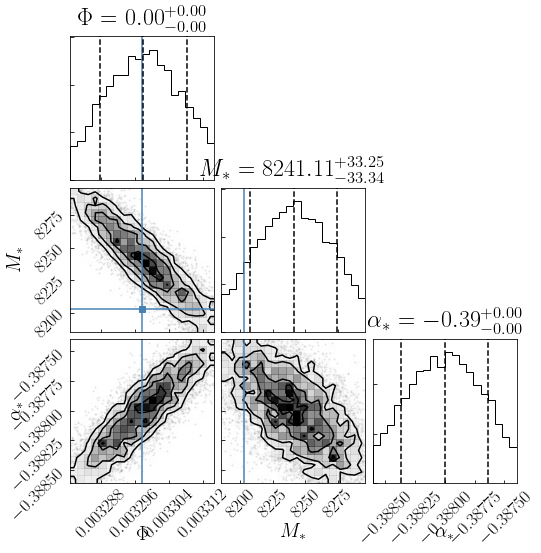

In [466]:
import corner
from matplotlib import rcParams
rcParams["font.size"] = 20
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

labels = [r"$\Phi$", r"$M_*$", r"$\alpha_*$"]
fig = corner.corner(
    flat_samples, labels=labels, truths=params,show_titles=True,quantiles=[.16,.50,.84],range=[0.90,0.90,0.90] 



#### MCMC with Thibaud's data

In [270]:
# maximum likelihood
import emcee
from scipy.optimize import minimize

# data
x = data_sf1[:,0]
y = 10**data_sf1[:,1]
yerr = 10**data_sf1[:,1]/50

params = mcmc_fit(x,y,yerr,chain_length=1000)
print(params)

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/lejay/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in power
  import sys
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in square
  from ipykernel import kernelapp as app
/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in true_divide
  from ipykernel import kernelapp as app
  0%|          | 0/1000 [00:00<?, ?it/

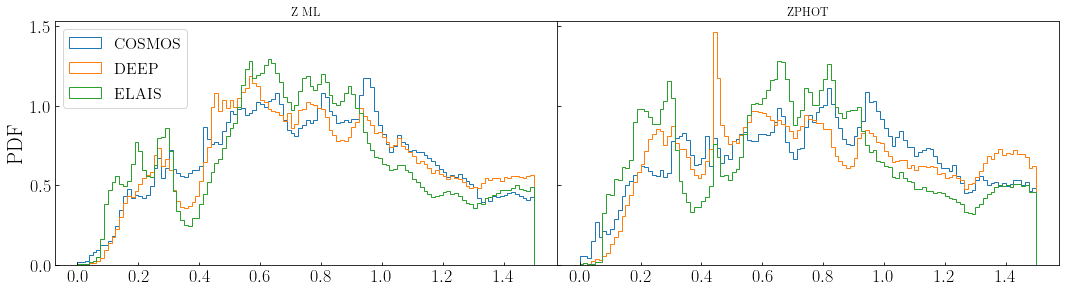

In [59]:
fig, axs = plt.subplots(1, 2, figsize = (18, 4.5),sharex=True,sharey=True)

for i, ztype in enumerate(['Z_ML','ZPHOT']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits')
        axs[i].hist(cat[ztype],range=(0.0,1.5),bins=120,histtype='step',cumulative=False,density=True,label=cat_name.replace('_deep',''))
    axs[i].set_title(ztype.replace('_',' '))

# cat_central_cosmos = Table.read(graham_output_dir+'cat_out_08squdeg_nonir_il_nz_prior_nolimit_formassc20added.fits')
# axs[0].hist(cat_central_cosmos['Z_ML'],range=(0.0,1.5),bins=100,histtype='step',color='k',cumulative=False,density=True,label='central COSMOS')
# axs[0].hist(cat_central_cosmos['lp_zPDF'],range=(0.0,1.5),bins=100,histtype='step',color='r',cumulative=False,density=True,label='C20')

axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)


9.43
8.17
6.81
14.66
13.42
11.64
9.41
7.87
6.15


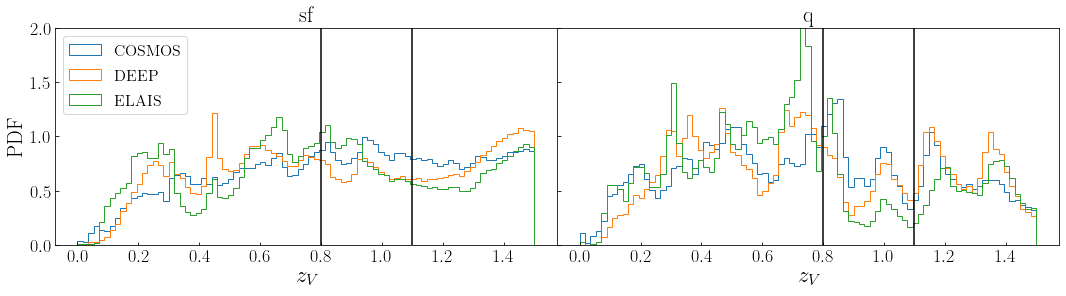

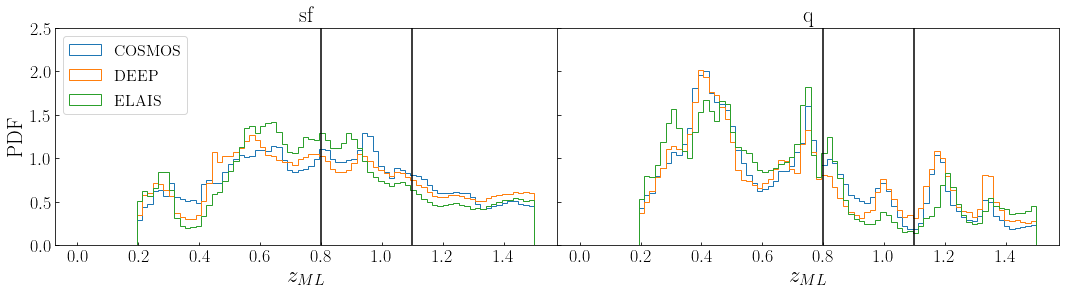

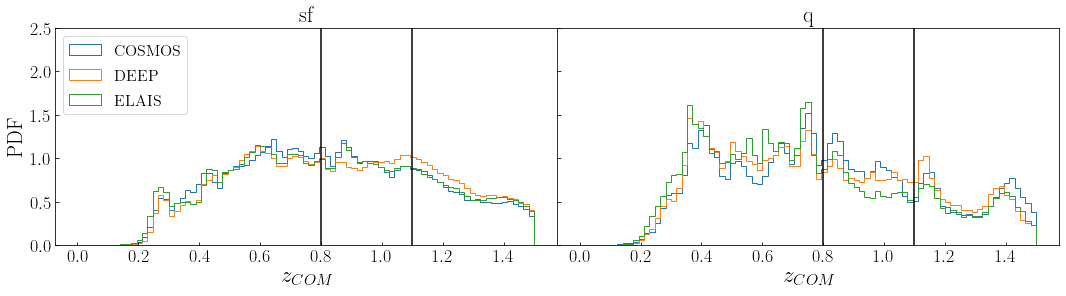

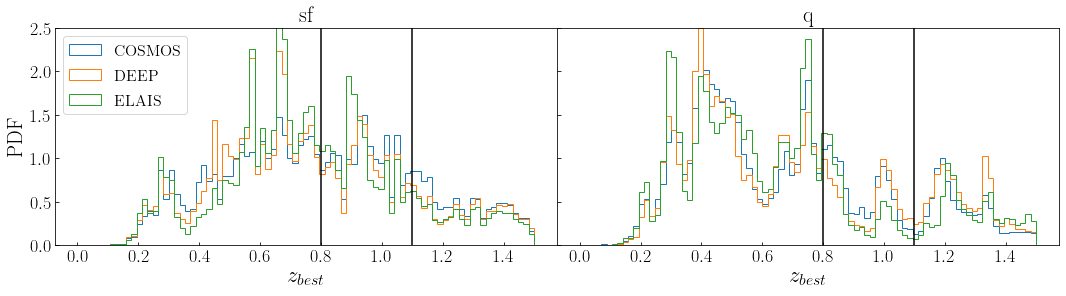

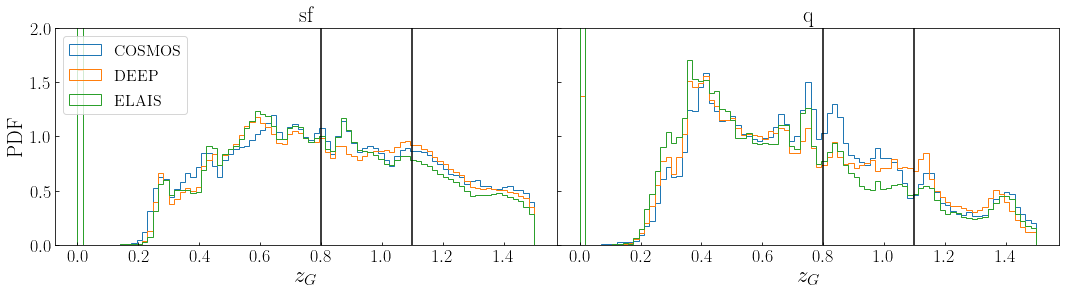

In [20]:
#######################################
# v9 Vincent's redshifts
fig, axs = plt.subplots(1, 2, figsize = (18, 4),sharex=True,sharey=True)
sfq_keyname = 'sfq_nuvrk'
ztype = 'ZPHOT'

for i, sfq in enumerate(['sf','q']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        cat = Table.read('/Users/lejay/research/massive_gals/clauds_cat_v2020/completeness_useful_params_cat/'+cat_name+'_v9_gal_cut_params_sfq_added.fits')
        
        if sfq == 'sf':
            cat = cat[cat[sfq_keyname]==1.0]
        else:
            cat = cat[cat[sfq_keyname]==0.0]
        axs[i].hist(cat[ztype],range=(0.0,1.5), bins=85, histtype='step', cumulative=False, density=True, label=cat_name.replace('_deep',''))
    axs[i].set_xlabel('$z_{V}$',fontsize=23)
    axs[i].set_title(sfq,fontsize=22)
    
    axs[i].vlines(x=0.8,ymin=0,ymax=2.5)
    axs[i].vlines(x=1.1,ymin=0,ymax=2.5)
    axs[i].set_ylim([0,2])
    
axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

#######################################
# my redshifts
fig, axs = plt.subplots(1, 2, figsize = (18, 4),sharex=True,sharey=True)
sfq_keyname = 'sfq_nuvrk_myrun_free'
ztype = 'Z_ML'

for i, sfq in enumerate(['sf','q']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
        
        if sfq == 'sf':
            cat = cat[cat[sfq_keyname]==1.0]
        else:
            cat = cat[cat[sfq_keyname]==0.0]
        n,bins,patches = axs[i].hist(cat[ztype],range=(0.0,1.5), bins=85, histtype='step', cumulative=False, density=True, label=cat_name.replace('_deep',''))
        
        if sfq == 'q':
            bins_ledges = bins[:-1]
            n_z = n[(bins_ledges>0.8) & (bins_ledges<1.1)]
            print(round(sum(n_z),2))
            
    axs[i].set_xlabel('$z_{ML}$',fontsize=23)
    axs[i].set_title(sfq,fontsize=22)
    axs[i].vlines(x=0.8,ymin=0,ymax=2.5)
    axs[i].vlines(x=1.1,ymin=0,ymax=2.5)
    axs[i].set_ylim([0,2.5])
    
axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

#######################################
# z_combine redshifts
fig, axs = plt.subplots(1, 2, figsize = (18, 4),sharex=True,sharey=True)
sfq_keyname = 'sfq_nuvrk_myrun_free'
ztype = 'Z_COMBINE'

for i, sfq in enumerate(['sf','q']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        cat = Table.read(graham_output_dir+'pcat_'+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
        
        if sfq == 'sf':
            cat = cat[cat[sfq_keyname]==1.0]
        else:
            cat = cat[cat[sfq_keyname]==0.0]
        n,bins,patches = axs[i].hist(cat[ztype],range=(0.0,1.5), bins=85, histtype='step', cumulative=False, density=True, label=cat_name.replace('_deep',''))
        
        if sfq == 'q':
            bins_ledges = bins[:-1]
            n_z = n[(bins_ledges>0.8) & (bins_ledges<1.1)]
            print(round(sum(n_z),2))
            
    axs[i].set_xlabel('$z_{COM}$',fontsize=23)
    axs[i].set_title(sfq,fontsize=22)
    axs[i].vlines(x=0.8,ymin=0,ymax=2.5)
    axs[i].vlines(x=1.1,ymin=0,ymax=2.5)
    axs[i].set_ylim([0,2.5])
    
axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

#######################################
# z_best
fig, axs = plt.subplots(1, 2, figsize = (18, 4),sharex=True,sharey=True)
sfq_keyname = 'sfq_nuvrk_myrun_free'
for i, sfq in enumerate(['sf','q']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
        
        if sfq == 'sf':
            cat = cat[cat[sfq_keyname]==1.0]
        else:
            cat = cat[cat[sfq_keyname]==0.0]
        n,bins,patches = axs[i].hist(cat['Z_BEST'],range=(0.0,1.5), bins=85, histtype='step', cumulative=False, density=True, label=cat_name.replace('_deep',''))
        
        if sfq == 'q':
            bins_ledges = bins[:-1]
            n_z = n[(bins_ledges>0.8) & (bins_ledges<1.1)]
            print(round(sum(n_z),2))
            
    axs[i].set_xlabel('$z_{best}$',fontsize=23)
    axs[i].set_title(sfq,fontsize=22)
    
    axs[i].vlines(x=0.8,ymin=0,ymax=2.5)
    axs[i].vlines(x=1.1,ymin=0,ymax=2.5)
    axs[i].set_ylim([0,2.5])
    
axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

#######################################
# with  guillaume's redshifts
fig, axs = plt.subplots(1, 2, figsize = (18, 4),sharex=True,sharey=True)
sfq_keyname = 'sfq_nuvrk_myrun_free'
for i, sfq in enumerate(['sf','q']):
    for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
        if cat_name == 'COSMOS_deep':
            ztype = 'ZPHOT_G_6B'
        else:
            ztype = 'ZPHOT_G'
            
        cat = Table.read(dev_path+cat_name+'_pcat_v9sfq_added.fits')
        
        if sfq == 'sf':
            cat = cat[cat[sfq_keyname]==1.0]
        else:
            cat = cat[cat[sfq_keyname]==0.0]
        axs[i].hist(cat[ztype],range=(0.0,1.5), bins=85, histtype='step', cumulative=False, density=True, label=cat_name.replace('_deep',''))
    axs[i].set_xlabel('$z_{G}$',fontsize=23)
    axs[i].set_title(sfq,fontsize=22)
    
    axs[i].vlines(x=0.8,ymin=0,ymax=2.5)
    axs[i].vlines(x=1.1,ymin=0,ymax=2.5)
    axs[i].set_ylim([0,2])
    
axs[0].set_ylabel('PDF',fontsize=21)
axs[0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)

Text(0, 0.5, 'flag IRAC')

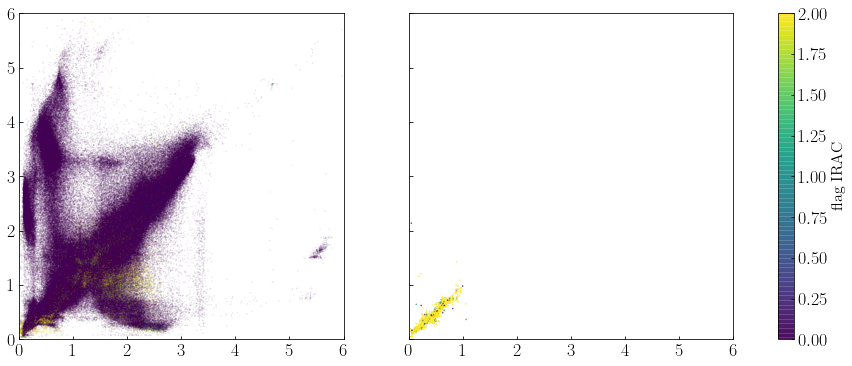

In [29]:
fig, axs = plt.subplots(1, 2, figsize = (16, 6),sharex=True,sharey=True)

cat_v9pcat = Table.read(graham_output_dir+'v9pcat_'+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass.fits')
cond_ch1 = ( (cat_v9pcat['MAG_AUTO_CH1'] > 0.) & (cat_v9pcat['MAG_AUTO_CH1'] < 50.) & (cat_v9pcat['MAGERR_AUTO_CH1'] > 0.) & (cat_v9pcat['MAGERR_AUTO_CH1'] < 0.5) )
cond_ch2 = ( (cat_v9pcat['MAG_AUTO_CH2'] > 0.) & (cat_v9pcat['MAG_AUTO_CH2'] < 50.) & (cat_v9pcat['MAGERR_AUTO_CH2'] > 0.) & (cat_v9pcat['MAGERR_AUTO_CH2'] < 0.5) )
flag_irac = cond_ch1.astype(int) + cond_ch2.astype(int) 

im = axs[0].scatter(cat_v9pcat['Z_ML'],cat_v9pcat['ZPHOT_G'], s=0.03, alpha=0.3, c=flag_irac)
axs[0].set_xlim([0,6])
axs[0].set_ylim([0,6])

im = axs[1].scatter(cat_v9pcat['ZSPEC'],cat_v9pcat['ZPHOT_G'], s=0.3, alpha=0.8, c=flag_irac)
axs[1].set_xlim([0,6])
axs[1].set_ylim([0,6])
cbar = fig.colorbar(im, ax=axs)
cbar.ax.set_ylabel('flag IRAC',fontsize=16)

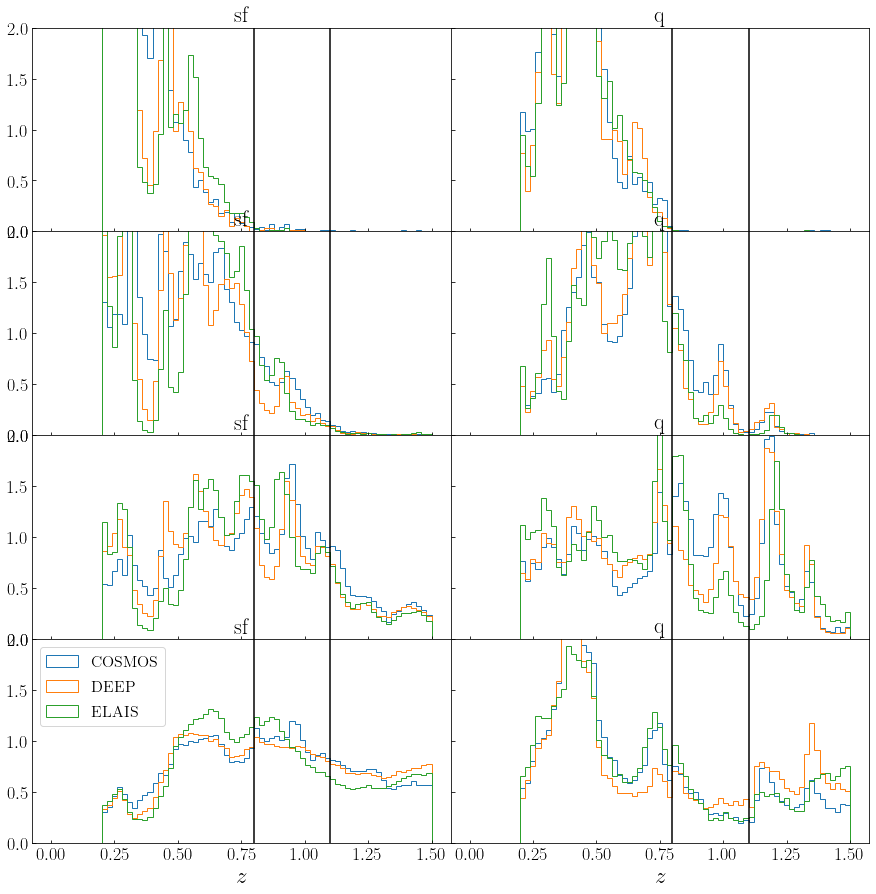

In [128]:
fig, axs = plt.subplots(4, 2, figsize = (15, 15),sharex=True,sharey=True)
sfq_keyname = 'sfq_nuvrk_myrun_free'
ztype = 'Z_ML'
mag_lows = [0,20,22,24]
mag_highs = [20,22,24,26]

for mag_idx in range(len(mag_lows)):
    for i, sfq in enumerate(['sf','q']):
        for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep']:
            cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
            cat = cat[cat['i']<mag_highs[mag_idx]]
            cat = cat[cat['i']>mag_lows[mag_idx]]
            
            if sfq == 'sf':
                cat = cat[cat[sfq_keyname]==1.0]
            else:
                cat = cat[cat[sfq_keyname]==0.0]
            axs[mag_idx][i].hist(cat[ztype],range=(0.0,1.5), bins=75, histtype='step', cumulative=False, density=True, label=cat_name.replace('_deep',''))
        
        axs[mag_idx][i].set_xlabel('$z$',fontsize=23)
        axs[mag_idx][i].set_title(sfq,fontsize=22)
        
        axs[mag_idx][i].vlines(x=0.8,ymin=0,ymax=2.5)
        axs[mag_idx][i].vlines(x=1.1,ymin=0,ymax=2.5)
        axs[mag_idx][i].set_ylim([0,2])
        
axs[mag_idx][0].legend(fontsize=16,loc='upper left')  
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)


#### galaxies in the peak

In [28]:
# median and average SED
sfq_keyname = 'sfq_nuvrk_myrun_free'
band_list = ['u','uS','g','r','i','z','y','MAG_AUTO_CH1_CORR','MAG_AUTO_CH2_CORR']
wl_list = [3679,3820,4809,6229,7702,8906,9777,35634,45110]

for band in band_list:
    detected_frac = []
    for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
        cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
        cat_z = cat[cat['Z_ML']>0.95]
        cat_z = cat_z[cat_z['Z_ML']<1.05]
        cat_zq = cat_z[cat_z[sfq_keyname]==0.0]
        
        cond = (cat_zq[band]>0) & (cat_zq[band]<50)
        detected_frac.append(round(len(cat_zq[cond])/len(cat_zq),3))
    print(band,detected_frac)

u [0.926, 0.866, 0.846]
uS [0.8, 0.0, 0.0]
g [0.977, 0.967, 0.963]
r [0.987, 0.994, 0.987]
i [1.0, 1.0, 1.0]
z [0.989, 0.994, 0.992]
y [0.987, 0.993, 0.992]
MAG_AUTO_CH1_CORR [0.737, 0.726, 0.762]
MAG_AUTO_CH2_CORR [0.712, 0.68, 0.685]


(53.3, 56.6)

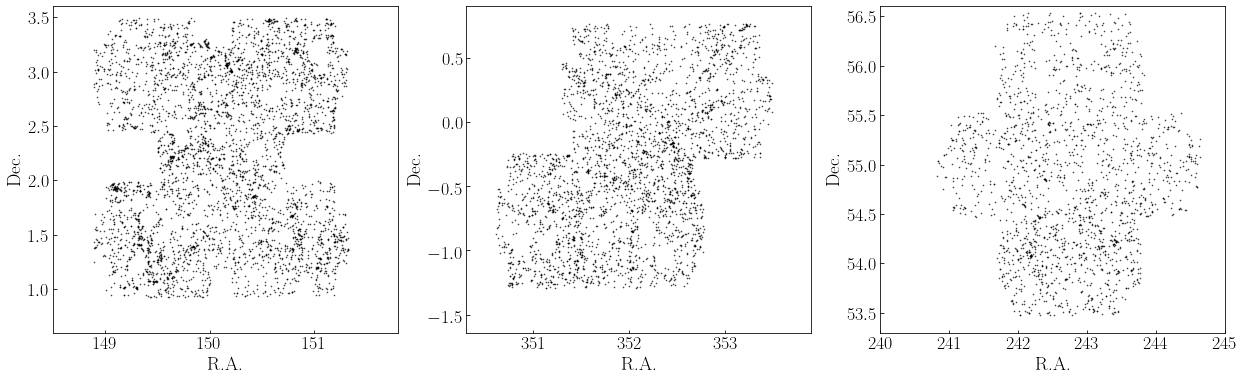

In [49]:
fig, axs = plt.subplots(1, 3, figsize = (21, 6))
sfq_keyname = 'sfq_nuvrk_myrun_free'

for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
    cat_z = cat[cat['Z_ML']>0.95]
    cat_z = cat_z[cat_z['Z_ML']<1.05]
    cat_zq = cat_z[cat_z[sfq_keyname]==0.0]
    
    axs[i].scatter(cat_zq['RA'], cat_zq['DEC'],s=0.4,color='k',alpha=0.7)
    axs[i].set_xlabel('R.A.',fontsize=19)
    axs[i].set_ylabel('Dec.',fontsize=19)
    
axs[0].set_xlim([148.5,151.8])
axs[0].set_ylim([0.6,3.6])

axs[1].set_xlim([350.3,353.9])
axs[1].set_ylim([-1.64,0.9])

axs[2].set_xlim([240.,245.])
axs[2].set_ylim([53.3,56.6])


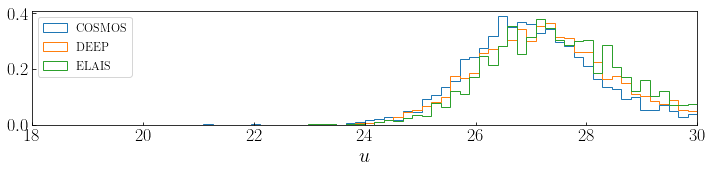

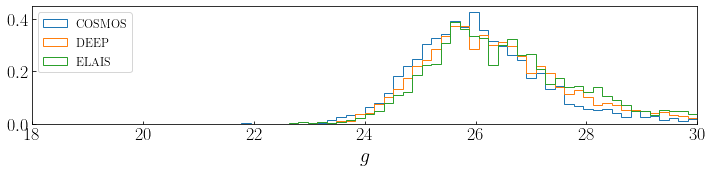

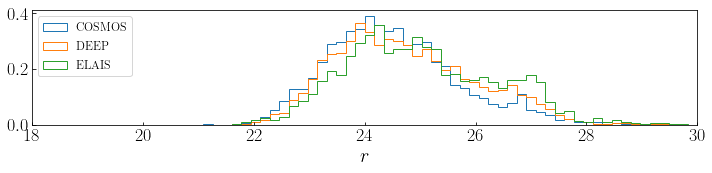

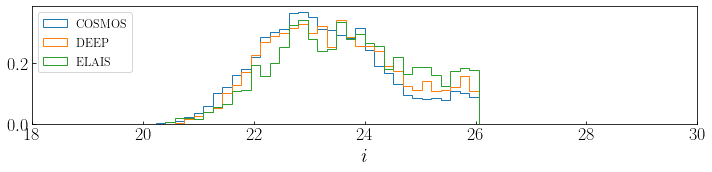

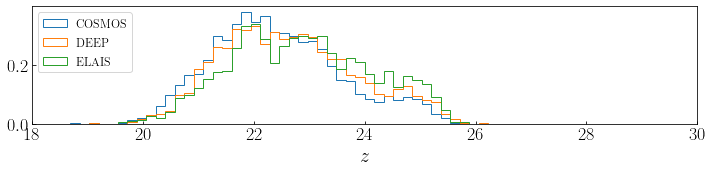

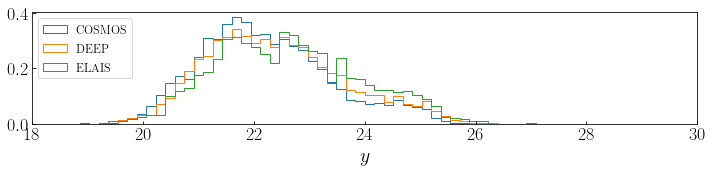

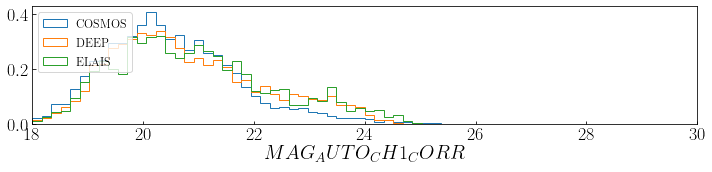

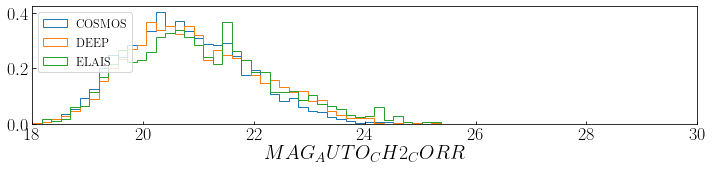

In [38]:
band_list = ['u','g','r','i','z','y','MAG_AUTO_CH1_CORR','MAG_AUTO_CH2_CORR']
for band in band_list:
    fig, axs = plt.subplots(1, 1, figsize = (10, 2.5))
    sfq_keyname = 'sfq_nuvrk_myrun_free'
    for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
        cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
        cat_z = cat[cat['Z_ML']>0.95]
        cat_z = cat_z[cat_z['Z_ML']<1.05]
        cat_zq = cat_z[cat_z[sfq_keyname]==0.0]
        plt.hist(cat_zq[band], bins=70, range=(18,30), histtype='step', density=True,label=cat_name.replace('_deep',''))
        
    plt.xlabel('$'+band+'$'.replace('_',' '),fontsize=20)
    plt.xlim([18,30])
    plt.legend(fontsize=12,loc='upper left')
    plt.tight_layout()
    

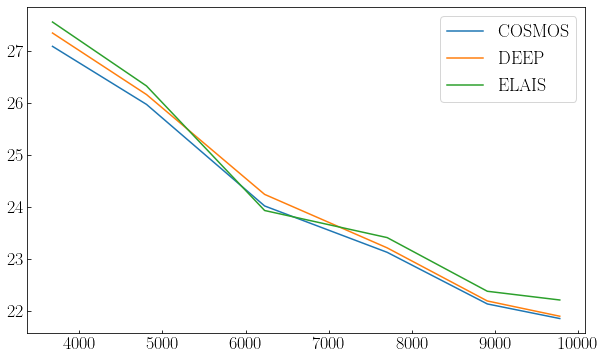

In [29]:
# median and average SED

fig, axs = plt.subplots(1, 1, figsize = (10, 6))
sfq_keyname = 'sfq_nuvrk_myrun_free'

# band_list = ['u','uS','g','r','i','z','y','MAG_AUTO_CH1_CORR','MAG_AUTO_CH2_CORR']
# wl_list = [3679,3820,4809,6229,7702,8906,9777,35634,45110]

band_list = ['u','g','r','i','z','y']
wl_list = [3679,4809,6229,7702,8906,9777]

for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
    cat_z = cat[cat['Z_ML']>0.95]
    cat_z = cat_z[cat_z['Z_ML']<1.05]
    cat_zq = cat_z[cat_z[sfq_keyname]==0.0]
    cat_zq = cat_zq[cat_zq['i']>-50]
    cat_zq = cat_zq[cat_zq['g']>-50]
    cat_zq = cat_zq[cat_zq['u']>-50]
    
    cat_zq = cat_zq[band_list]
    median_mag = []
    for band in band_list:
        median_mag.append(np.nanmean(cat_zq[band]))
    
    plt.plot(wl_list,median_mag,label=cat_name.replace('_deep',''))

plt.legend(fontsize=18)

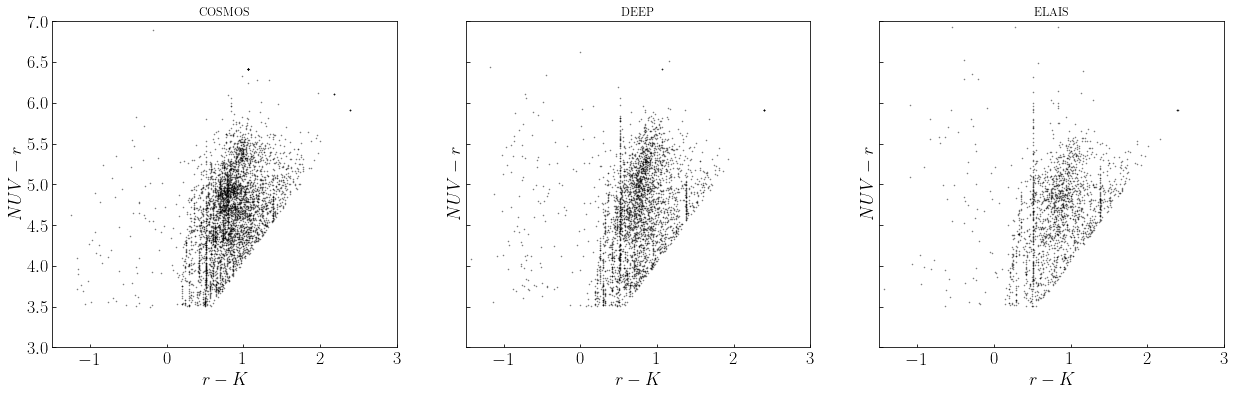

In [52]:
fig, axs = plt.subplots(1, 3, figsize = (21, 6), sharex=True, sharey=True)

for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep']):
    cat = Table.read(graham_output_dir+cat_name+'_cat_out_nomaglimit_nonir_il_nz_prior_formass_sfq_added.fits')
    cat_z = cat[cat['Z_ML']>0.95]
    cat_z = cat_z[cat_z['Z_ML']<1.05]
    cat_zq = cat_z[cat_z[sfq_keyname]==0.0]
    
    axs[i].scatter(cat_zq['MAG_ABS_r']-cat_zq['MAG_ABS_Ks'],cat_zq['MAG_ABS_NUV']-cat_zq['MAG_ABS_r'],s=0.3, color='k',alpha=0.5)
    axs[i].set_xlim([-1.5,3])
    axs[i].set_ylim([3,7])
    
    axs[i].set_xlabel('$r-K$',fontsize=18)
    axs[i].set_ylabel('$NUV-r$',fontsize=18)
    axs[i].set_title(cat_name.replace('_deep',''))